### Model analysis

In [ ]:
# sklearn version needs to be >= 0.23.
!pip install -U scikit-learn

     |████████████████████████████████| 22.3 MB 1.2 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [ ]:
import sklearn
sklearn.__version__

'0.24.2'

In [ ]:
!pip install --upgrade shap

import math
import os
import shap
import torch

import numpy as np
import pandas as pd
# import matplotlib.pylab as pl

import pickle

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data

from torch.utils.data.dataset import Dataset

from sklearn.model_selection import train_test_split, cross_val_score, KFold

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import OneHotEncoder, normalize
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from sklearn.utils import resample

from sklearn.feature_selection import VarianceThreshold

     |████████████████████████████████| 356 kB 10.9 MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491648 sha256=e9d22b5c564fcac0ddd2a9d62643056ae44f1022d92551f5bcccef687ad23025
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap


In [ ]:
from google.colab import drive
if not os.path.exists("/content/drive"):
  drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# read pre-processed BUT not imputed full data (not stratified by age)
fullData = pd.read_csv('/content/drive/MyDrive/BITSBITSBITS<3/clean_data_total.csv', index_col=0, dtype=int)

In [ ]:
fullData.head()

,fever,total_days_fever,tos,dysphonia,resp,tachypnea,ausc_resp,ausc_type,odynophagia,nasal_congestion,fatiga,headache,conjuntivitis,gi_symptoms,abdominal_pain,vomiting,dyarrea,dermatologic,rash,adenopathies,hemorrhagies,irritability,neuro,shock,taste_smell,smell,final_diagnosis_code
0,1,1,1,0,1,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0
1,2,1,1,0,0,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0
2,2,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0
3,0,0,1,1,1,0,1,1,-1,0,0,-1,0,0,0,0,0,0,0,0,0,1,0,0,-1,-1,0
4,3,1,1,0,0,0,0,0,-1,1,0,-1,0,1,0,1,0,0,0,0,0,0,0,0,-1,-1,0


### 1. Preliminar definitions

We define functions that will be used during the process:

- That undersamples data
- That renames one-hotted columns so that they are more understandable when performing importance analysis

In [ ]:
def undersample_data(X, y, randomState, negProp=0.5):
  """ Undersample data.
    :param X: (ndarray) data to undersample.
    :param y: (ndarray) binary ground truth labels.
    :param randomState: (int) random state.
    :param negProp: (float) float between 0 and 1 indicating the proportion
                    of negative samples desired. Default: 0.5 """

  rng = np.random.default_rng(randomState)
  nPositive = sum(y)
  nNegative = len(y) - nPositive
  sampleSize = round((negProp * nPositive) / (1 - negProp))
  if sampleSize > nNegative:
    raise Exception('There are not that many negative samples in the data')
  chosenNegatives = rng.choice(list(range(nNegative)), size=sampleSize)
  XNeg, yNeg = X[y == 0][chosenNegatives], y[y == 0][chosenNegatives]
  X = np.concatenate((X[y == 1], XNeg))
  y = np.concatenate((y[y == 1], yNeg))

  # shuffle
  shuffler = rng.permutation(len(y))
  X = X[shuffler]
  y = y[shuffler]
  
  return X, y

def remove_variance(data: pd.DataFrame, pctThreshold: float) -> pd.DataFrame:
  """ Delete columns from data that comprise less than 'threshold'% of variance. """
  sel = VarianceThreshold()

  dataNan = data.copy()
  dataNan[dataNan == -1] = np.NaN

  # fit to compute threshold variance percentile
  sel.fit(dataNan)
  # l1 normalisation (sum to 1)
  normVars = normalize(sel.variances_.reshape(1, -1), norm='l1').squeeze()

  threshold = np.max(sel.variances_[normVars < pctThreshold])
  sel = VarianceThreshold(threshold=threshold)
  dataThres = sel.fit_transform(dataNan)

  a = np.sort(np.array(list(zip(sel.variances_, data.columns))))
  print(a)
  delCols = {data.columns[i]: round(normVars[i], 5) for i in np.where(sel.variances_ <= threshold)[0]}
  print(f'Deleted {len(delCols)} variables: {delCols}')

  return data.loc[:, set(data.columns) - set(data.columns[np.where(sel.variances_ <= threshold)[0]])]

 ## 2. Training pipeline

We define a function that performs the following procedure for some model type (SVM, NN, XGBoost...) and some manually defined hyperparam. configurations.

Algorithm 1 (Modeling):

1. Split the data into training (TOTAL) and test.
2. For each Cross Validation Repeat:
  2.1. For each Cross Validation fold:
    - split training (TOTAL) into training and validation.
    - impute training ALONE -> impute validation WITH training
    - one-hot both training and validation
    - undersample the training data
    - For each hyperparam configuration:
        - train model on training data
        - compute AUC, sensitivity, specificity, precision, F1 on validation data
3. Pick best configurations by performing pairwise t-tests with the obtained metrics
3. Average and save metrics for each config. across folds and CV repeats.
4. Impute training (TOTAL) -> Impute test WITH training (TOTAL)
5. Onehot training (TOTAL) and test
6. Undersample training (TOTAL)
7. Pick the best config. and boostrap to obtain test Confidence Intervals: train model with training (TOTAL) and evaluate on test
8. Return best config and evaluation metrics

Note that the imputation is performed in steps to prevent information leakage from the validation / test sets to the training sets. Moreover, the onehot is performed after imputing imputation because if it was the other way around the imputation would have to deal with more features.


In [ ]:
from numpy import median
from numpy import percentile
from scipy.stats import ttest_rel


def eval_model(modelClass, trainingData, testData, configs, inputNNeigh=5,
               missingVal=-1, target='final_diagnosis_code', nCVs=5, CVFolds=2, 
               USnegProp=0.5, nBootstraps=100, bootstrapTest=True, imputeMaxIter=5, 
               verbose=True, randomState=888):
  """ CV Training and evaluation pipeline that follows the procedure described above 
  (not including split into training and validation) with some predefined configurations.

  Prints the best found configuration and performance metrics. The best configuration
  is found with 5 x 2-fold CV and comparing average validation AUCs with paired t-tests as 
  recommended in https://ieeexplore.ieee.org/document/6790639

  :param modelClass: (model method) Model class to test configurations on. Note that the parameter
                     should not be the initialized model, but rather the instancer
                     (i.e. 'network' instead of 'network()'). The class must implement
                     a 'fit(X, y)' training method, as well as a 'predict(X)' method for class
                     prediction, which returns the predicted label for a batch of
                     instances X. 
  :param trainingData: (pd.DataFrame) training dataset. 
  :param testData: (pd.DataFrame) test dataset. 
  :param configs: (iterable of dicts) Iterable containing the different model 
                  configurations. Each configuration must be a dictionary with
                  the keys being the exact parameter names and the entries
                  being the desired parameter value. Note that the configurations
                  must be able to be done via the initialization of a 'modelClass' 
                  instance.
  :param OHEncoder: (sklearn.preprocessing.OneHotEncoder) Fitted one-hot encoder.
  :param inputNNeigh: (int, optional) number of instances considered when imputing with KNN.
  :param missingVal: (int, optional) value that represents a missing in the data.
  :param target: (str, optional) name of the target column.
  :param nCVs: (int, optional) number of times the cross validation is repeated
    (with different data in the folds).
  :param CVFolds: (int, optional) number of cross validation folds.
  :param USnegProp: (float) float between 0 and 1 indicating the proportion of 
                    negative samples when undersampling.
  :param nBootstraps: (int) number of bootstrap rounds
  :param bootstrapTest: (bool, default True) should CIs be extracted from test via bootstrapping?
  :param imputeMaxIter: (int) maximum iterations of iterative imputer.
  :param verbose: (bool, default True) Print info. during the execution?
  :param randomState: (int, optional) random state for all purposes.
  :return: bestAUCs (list), valMetrics (dict), testMetrics (dict), CIs (dict of tuples), 
           config (dict), trainedModel (callable), trainData (list), 
           testData (list), OHFeatureNames (list):
           - bestAUCs: list with the CV validation AUCs of length nCVs * CVFolds
           - valMetrics: average evaluation metrics on the CV validation sets of the best configuration.
           - testMetrics: median bootstrap evaluation (if bootstrapTest=True) 
           or single (if bootstrapTest=False) metrics on the test set given all of the training data of the best configuration
           - CIs: confidence intervals @95% for the test metrics (only if bootstrapTest=True)
           - config: best parameter configuration. 
           - trainedModel: model instance trained with the best configuration that
                           was used to compute the test scores. 
           - trainData: X and y, data used to train the best model (undersampled and imputed). 
           - testData: X and y, data used to test the best model (imputed) 
           - OHfeatureNames: list of strs. representing the feature names of the OH
                             representation of the data. """

  rng = np.random.default_rng(randomState)

  # fit a one-hot encoder with all the possible features in the data (without the target)
  # because the dataset has missing values (-1), we first replace them with an existing value (0). 
  # This deletion is local and only done to initialise the encoder: the missing values will
  # be imputed further down the pipeline.
  # This step does not create information leakage.
  OHEncoder = OneHotEncoder(sparse=False, drop='first')
  OHEncoder.fit(pd.concat((trainingData, testData), axis=0)
                          .drop(target, axis=1)
                          .replace(to_replace=-1, value=0))

  # for each config we will have a dict. containing the specific configuration
  # and its performance metrics across the CV pipeline
  baseMetrics = {'AUC': 0, 'prec': 0, 'sensitivity': 0, 'specificity': 0, 'F1': 0}
  allMetrics = [{**config, **baseMetrics} for config in configs]

  # we will need arrays with the results for the statistical tests.
  for i in range(len(configs)):
    allMetrics[i]['AUC'] = []

  # split target and data and transform to numpy
  yTrainTotal = trainingData.loc[:, target].to_numpy(dtype=int)
  XTrainTotal = trainingData.drop(target, axis=1)

  if verbose:
    print(XTrainTotal.columns)

  XTrainTotal = XTrainTotal.to_numpy()

  yTest = testData.loc[:, target].to_numpy(dtype=int)
  XTest = testData.drop(target, axis=1).to_numpy()

  for nCV in range(nCVs):
    # pre-split training data into folds
    folds = KFold(n_splits=CVFolds, shuffle=True, random_state=randomState+nCV)
    if verbose:
      print(f'\n{nCV+1}/{nCVs} CV')
    foldIndex = 0
    for trainIndexes, valIndexes in folds.split(XTrainTotal):
      if verbose:
        print(f'\nFold {foldIndex+1}/{CVFolds}...')
      # get actual CV splits
      XTrain, XVal = XTrainTotal[trainIndexes], XTrainTotal[valIndexes]
      yTrain, yVal = yTrainTotal[trainIndexes], yTrainTotal[valIndexes]
      # impute training first and then validation with training in mind
      # to prevent information leakage
      maxValueTrainInput = np.max(XTrain, axis=0)
      maxValueValInput = np.max(np.concatenate((XTrain, XVal), axis=0), axis=0)
      
      for i in range(len(maxValueTrainInput)):
        if maxValueTrainInput[i] == 0:
          # variable does not have multiple levels. Set its max. value to 1 as 
          # a minor hack to the IterativeImputer -> it raises an error if min and
          # max value is the same. This does not make it impute invalid values.
          maxValueTrainInput[i] = 1
        if maxValueValInput[i] == 0:
          maxValueValInput[i] = 1

      imputer = IterativeImputer(estimator=KNeighborsClassifier(n_neighbors=inputNNeigh),
                                missing_values=missingVal,
                                initial_strategy='median',
                                min_value=0,
                                max_value=maxValueTrainInput,
                                max_iter=imputeMaxIter,
                                skip_complete=True,
                                random_state=randomState)
      XTrain = imputer.fit_transform(XTrain)
      imputer = IterativeImputer(estimator=KNeighborsClassifier(n_neighbors=inputNNeigh),
                                missing_values=missingVal,
                                initial_strategy='median',
                                min_value=0,
                                max_value=maxValueValInput,
                                skip_complete=True,
                                max_iter=imputeMaxIter,
                                random_state=randomState)
      XVal = imputer.fit(np.concatenate((XTrain, XVal), axis=0)).transform(XVal)

      # one-hot imputed data
      XTrain = OHEncoder.transform(XTrain)
      XVal = OHEncoder.transform(XVal)
      # undersample the training split
      XTrain, yTrain = undersample_data(XTrain, yTrain, rng, negProp=USnegProp)
      # for each config, train and validate
      configIndex = 0
      for config in configs:
        configMetrics = baseMetrics
        # train model
        model = modelClass(**config)
        model.fit(XTrain, yTrain)
        preds = model.predict(XVal)
        # compute validation metrics
        tn, fp, fn, tp = confusion_matrix(yVal, preds).ravel()
        configMetrics['AUC'] = [roc_auc_score(yVal, preds)]
        configMetrics['prec'] = tp / (tp + fp)
        configMetrics['sensitivity'] = tp / (tp + fn)
        configMetrics['specificity'] = tn / (tn + fp)
        configMetrics['F1'] = f1_score(yVal, preds)
        for metric in baseMetrics.keys():
            allMetrics[configIndex][metric] += configMetrics[metric]
        configIndex += 1
      foldIndex += 1

  # Get best configurations by statistically comparing the resulting AUCs
  bestAUCs = [-1 for _ in range(nCVs * CVFolds)]
  bestConfig = None
  bestPVal = np.inf
  bestConfigIndex = -1

  for i, configMetrics in enumerate(allMetrics):
    for metric in baseMetrics.keys():
      if metric != 'AUC':
        configMetrics[metric] /= nCVs * CVFolds

    # paired t-test
    pVal = ttest_rel(configMetrics['AUC'], bestAUCs)[1]
    if i == 0:
      firstPVal = pVal
    if pVal <= 0.05 and np.mean(configMetrics['AUC']) > np.mean(bestAUCs):
      bestAUCs = configMetrics['AUC']
      bestConfig = configMetrics
      bestPVal = pVal
      bestConfigIndex = i

  if verbose:
    if firstPVal == bestPVal:
      print(f'First configuration appears to perform as well as the others (no statistical difference between configurations).')
    else:
      print(f'\nFound best configuration with p-value {round(bestPVal, 5)}')

  bestConfig['AUC'] = np.mean(bestConfig['AUC'])

  if verbose:
    print('Imputing full train dataset...')
  # impute whole train data (without splitting for CV) and test
  maxValueTrainTotalInput = np.max(XTrainTotal, axis=0)
  maxValueTestInput = np.max(np.concatenate((XTrainTotal, XTest), axis=0), axis=0)

  tr, ts = None, None
  for i in range(len(maxValueTrainTotalInput)):
    if maxValueTrainTotalInput[i] == 0:
      # variable does not have multiple levels, so maximum value needs to be bigger
      # than the minimum. The variable will be imputed with the same level, so
      # this does not introduce wrong levels.
      maxValueTrainTotalInput[i] = 1
      tr = i
    if maxValueTestInput[i] == 0:
      maxValueTestInput[i] = 1
      ts = i

  imputer = IterativeImputer(estimator=KNeighborsClassifier(n_neighbors=inputNNeigh),
                             missing_values=missingVal,
                             initial_strategy='median',
                             min_value=0,
                             max_value=maxValueTrainTotalInput,
                             skip_complete=True,
                             max_iter=imputeMaxIter,
                             random_state=randomState)
  XTrainTotal = imputer.fit_transform(XTrainTotal)
  imputer = IterativeImputer(estimator=KNeighborsClassifier(n_neighbors=inputNNeigh),
                             missing_values=missingVal,
                             initial_strategy='median',
                             min_value=0,
                             max_value=maxValueTestInput,
                             skip_complete=True,
                             max_iter=imputeMaxIter,
                             random_state=randomState)
  XTest = imputer.fit(np.concatenate((XTrainTotal, XTest), axis=0)).transform(XTest)

  # one hot whole train and test datasets
  XTrainTotal = OHEncoder.transform(XTrainTotal)
  XTest = OHEncoder.transform(XTest)

  # undersample
  XTrainTotal, yTrainTotal = undersample_data(XTrainTotal, yTrainTotal, rng, negProp=USnegProp)

  if bootstrapTest is True and verbose:
    print('\nBootstrapping test...')
  elif bootstrapTest is False:
    nBootstraps = 1

  metricsTest = {'AUC': [], 'prec': [], 'sensitivity': [], 'specificity': [], 'F1': []}
  for i in range(nBootstraps):
      XBoots, yBoots = resample(XTrainTotal, yTrainTotal, random_state=randomState+i)

      # train best configuration with the bootstrapped training set and 
      # get metrics for the test data
      bestModel = modelClass(**configs[bestConfigIndex])
      bestModel.fit(XBoots, yBoots)
      preds = bestModel.predict(XTest)
      tn, fp, fn, tp = confusion_matrix(yTest, preds).ravel()
      metricsTest['AUC'].append(roc_auc_score(yTest, preds))
      metricsTest['prec'].append(tp / (tp + fp))
      metricsTest['sensitivity'].append(tp / (tp + fn))
      metricsTest['specificity'].append(tn / (tn + fp))
      metricsTest['F1'].append(f1_score(yTest, preds))

  if bootstrapTest is True:
    # get 95% confidence intervals
    alpha = 5
    lowerP = alpha / 2
    upperP = (100 - alpha) + (alpha / 2)
    CIs = {}
    for metric, values in metricsTest.items():
      CIs[metric] = (percentile(values, lowerP), percentile(values, upperP))
      metricsTest[metric] = median(values)    

    return bestAUCs, {valMetric: bestConfig[valMetric] for valMetric in baseMetrics.keys()}, \
          metricsTest, CIs, configs[bestConfigIndex], bestModel, [XTrainTotal, yTrainTotal], \
          [XTest, yTest], OHEncoder.get_feature_names(trainingData.drop(target, axis=1).columns)

  else:
    # w/o confidence intervals if we do not have bootstrapping
    return bestAUCs, {valMetric: bestConfig[valMetric] for valMetric in baseMetrics.keys()}, \
          metricsTest, configs[bestConfigIndex], bestModel, [XTrainTotal, yTrainTotal], \
          [XTest, yTest], OHEncoder.get_feature_names(trainingData.drop(target, axis=1).columns)

## 3. Model evaluation pipeline

We search for the best configuration for some model architectures given the following data sets:

- Full data set (no age strata)
- Ages 0 to 5 data set
- Ages 6 to 17 data set
- Full data set (no age strata and with incidence as a feature)


First, an example of how the eval_model function works with the XGBoost architecture:

In [ ]:
from xgboost.sklearn import XGBClassifier

# let us define 70 / 30 train test splits
randomState = 888
rng = np.random.default_rng(randomState)
trainIndexes = rng.choice([True, False], size=len(fullData), p=[0.7, 0.3])
fullDataTrain, fullDataTest = fullData[trainIndexes], fullData[~trainIndexes]

# common parameter values
inputNNeigh = 10
missingVal = -1
nCVs = 5
CVFolds = 2
USnegProp = 0.5
imputeMaxIter = 5

# XGBoost config options
XGBGrid = {'learning_rate': [0.1, 0.01, 0.001],
           'n_estimators': [100, 300, 500],
           'max_depth': [2, 4, 6, 8],
           'subsample': [0.25, 0.5, 0.8],
           'random_state': [randomState]}

# n random configurations
n = 2
rng = np.random.default_rng(randomState)
XGBConfigs = [{paramKey: rng.choice(XGBGrid[paramKey], size=1).item() for paramKey in XGBGrid.keys()} for _ in range(n)]

# evaluate
bestAUCs, valMetrics, testMetrics, CIs, bestConfig, \
trainedModel, trainData, testData, fNames = eval_model(modelClass=XGBClassifier, 
                                                        trainingData=fullDataTrain, 
                                                        testData=fullDataTest, 
                                                        configs=XGBConfigs,
                                                        inputNNeigh=inputNNeigh,
                                                        missingVal=missingVal,
                                                        nCVs=nCVs,
                                                        CVFolds=CVFolds,
                                                        USnegProp=USnegProp,
                                                        imputeMaxIter=imputeMaxIter,
                                                        randomState=randomState)
print()
print(bestAUCs)
print(valMetrics)
print(testMetrics)
print(CIs)
print(bestConfig)
print(trainedModel)

In [ ]:
def eval_model_pipeline(modelClasses, modelConfigs, trainingData, testData, **kwargs):
  """ Measures performance of multiple model architectures with different 
      configurations following Algorithm 1.

  :param modelClasses: (list-like of model methods) methods to evaluate. Each element
                       of the collection is the model instancer (i.e. 'network' 
                       instead of 'network()'). Each class must implement
                       a 'fit(X, y)' training method, as well as a 'predict(X)' 
                       method for class prediction, which returns the predicted 
                       label for a batch of instances X. 
  :param modelConfigs: (2D list-like of dicts) A list containing, for each modelClass, 
                       a list of architecture configurations represented as dicts.
                       modelConfigs[i] corresponds to the configurations for modelClasses[i].
  :param trainingData: (pd.DataFrame) Unimputed and unbalanced training data (including the target).
  :param testData: (pd.DataFrame) Unimputed test data (including the target).
  :param kwargs: extra keyword arguments that will be passed onto 'eval_model()'.
  :return: (pd.DataFrame, pd.DataFrame, dict of dicts, dict of callables, list, list)
           - average validation evaluation metrics
           - test evaluation metrics for the best configuration of each model 
             class in 'modelClasses' with 95% confidence intervals
           - best performing configurations for each model class in 'modelClasses' 
           - the trained models used to compute the test scores, respectively. 
           - trainData (X and y) used to train all of the models (imputed and undersampled) 
           - testData (X and y) used to test all of the best models configurations. (imputed) """

  resEntries = ['Arch', 'AUC', 'AUC CIs', 'sensitivity', 'sensitivity CIs', 
                'specificity', 'specificity CIs', 'prec', 'prec CIs', 'F1', 'F1 CIs']

  valEntries = ['Arch', 'AUC', 'prec', 'sensitivity', 'specificity', 'F1']

  bestArchitectures = {}
  trainedModels = {}

  resVal = []
  resTest = []
  for i, modelClass in enumerate(modelClasses):
    print(f'\nEvaluating {modelClass}')
    _, valScores, testScores, CIs, bestConfig, \
    trainedModel, finalTrData, finalTestData, OHfNames = eval_model(modelClass=modelClass, 
                                                                    configs=modelConfigs[i], 
                                                                    testData=testData, 
                                                                    trainingData=trainingData,
                                                                    bootstrapTest=True,
                                                                    verbose=True,
                                                                    **kwargs)
    valScores['Arch'] = str(modelClass)
    testScores['Arch'] = str(modelClass)

    resValModel = []
    resTestModel = []

    for metric in valEntries:
      resValModel.append(valScores[metric])
    resVal.append(resValModel)

    for metric in valEntries:
      if metric == 'Arch':
        resTestModel.append(testScores[metric])
      else:
        resTestModel.append(testScores[metric])
        resTestModel.append(CIs[metric])
    resTest.append(resTestModel)

    bestArchitectures[str(modelClass)] = bestConfig
    trainedModels[str(modelClass)] = trainedModel

  resultsVal = pd.DataFrame(data=resVal, columns=valEntries)
  resultsTest = pd.DataFrame(data=resTest, columns=resEntries)
  
  return resultsVal, resultsTest, bestArchitectures, trainedModels, finalTrData,\
         finalTestData, OHfNames

Definition of architectures to use, hyperparameters and configurations to try. 

---



### 3.1 Custom FCNN architecture

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class MLP(nn.Module):
    """ Fully connected network (Multi-layer perceptron) semi-skeleton. The size of intemediate layers need to be defined.
    This class is meant to be trained with its .fit method. """

    def __init__(self, linearLayerSizes, nDropOutLayers=0.5, dropOutP=0.1, 
                 batchSize=15, nEpochs=30, initLR=1e-3, activation='relu', randomState=888):
      """ dropOut layers will be randomly applied to some of the provided Linear Layers.
      ReLU activations will follow all linear layers. The model will return probabilities.

      :param linearLayerSizes: (array-like) array containing the input and output sizes of 
      the intermediate nn.Linear layers as multipliers of the number of features in the data, 
      in order of execution. Note that the first and last layers are already implemented: 
      first layer casts to size round(inputOutputScale*inputSize), last layer casts from size
      round(inputOutputScale*inputSize). inputOutputScale will be induced from the first
      entry of the first linear layer in linearLayerSizes. The following is a correct example of linearLayerSizes, 
      equivalent to having intermediate Linear layers of shapes (round(inputScale*inputSize), 2*inputSize)
      and (2*inputSize, round(outputScale*inputSize)):

      >>> linearLayerSizes = [(inputScale, 2), (2, outputScale)]

      :param nDropOutLayers: (int or float) if int, indicates the number of intemediate linear
      layers that will be followed by a dropout <= len(linearLayerSizes). If float,
      it will indicate the percentage of linear layers that will be followed by a dropout
      and ceil(len(linearLayerSizes) * nDropOutLayers) will be picked. In both cases, which
      layers are followed by the dropout will be randomly chosen.
      :param dropOutP: (float) percentage of dropout for the picked layers. 
      :param batchSize: (int) batch size for training 
      :param nEpochs: (float) number of epochs used for training 
      :param initLR: (float) initial learning rate for the adaptive optimizer 
      :param activation: (str) Nonlinear activation function to use:
        - 'relu': rectified linear unit 
        - 'rrelu': randomized leaky rectified linear unit
        - 'sigmoid': sigmoid
        - 'tanh': hyperbolic tangent"""

      super(MLP, self).__init__()
      torch.manual_seed(randomState)  

      if activation == 'relu':
        self.activation = F.relu
      elif activation == 'rrelu':
        self.activation = F.rrelu
      elif activation == 'sigmoid':
        self.activation = torch.sigmoid
      elif activation == 'tanh':
        self.activation = torch.tanh
      else:
        raise ValueError(f"{activation} activation not valid. Use one in {['relu', 'rrelu', 'sigmoid', 'tanh']}")

      self.rng = np.random.default_rng(randomState)

      self.inputScale = None
      self.outputScale = None

      # it will be induced when calling the .fit method
      self.inputSize = None

      # their input and output sizes will be adjusted when self.inputSize is induced
      self.firstLinLayer = nn.Linear(1, 2)
      self.lastLinLayer = nn.Linear(2, 1)

      # will be filled when self.inputSize is induced in the .fit method
      self.linearLayers = []
      self.linearLayerSizes = linearLayerSizes

      if isinstance(nDropOutLayers, int):
        self.nDropOutLayers = nDropOutLayers
      elif isinstance(nDropOutLayers, float):
        self.nDropOutLayers = math.ceil(nDropOutLayers * len(self.linearLayerSizes))

      if self.nDropOutLayers > len(self.linearLayerSizes) or self.nDropOutLayers < 0:
        raise ValueError(f'Invalid number of dropout layers ({self.nDropOutLayers})')

      # indexes of layers that will be followed by a dropout layer.
      self.dropOutIndexes = set(rng.choice(list(range(len(self.linearLayerSizes))), 
                                           size=self.nDropOutLayers,
                                           replace=False))

      self.dropOut = nn.Dropout(dropOutP)
      self.batchSize = batchSize
      self.nEpochs = nEpochs
      self.initLR = initLR

      self.criterion = None
      self.optimizer = None

    def forward(self, x):
      """ :param x: (torch.FloatTensor) of shape (nSamples, inputSize) """

      out = self.activation(self.firstLinLayer(x))
      for i, linearLayer in enumerate(self.linearLayers):
        out = self.activation(linearLayer(out))
        if i in self.dropOutIndexes:
          out = self.dropOut(out)

      # return raw scores
      return self.lastLinLayer(out)

    def fit(self, X, y):
      """ 
      :param X: (np.ndarray) of shape (nSamples, inputSize)
      :param y: (np.ndarray) of shape (nSamples,) """

      # input size is induced when calling this method for similarity to the sklearn
      #  API. The first and last linear layer sizes are adjusted accordingly.

      self.inputSize = X.shape[1]

      # instantiate intermediate layers
      for i, shape in enumerate(self.linearLayerSizes):

        if i == 0:
          self.inputScale = shape[0]
        elif i == len(self.linearLayerSizes) - 1:
          self.outputScale = shape[1]

        inputSize = round(shape[0] * self.inputSize)
        outputSize = round(shape[1] * self.inputSize)

        self.linearLayers.append(nn.Linear(inputSize, outputSize))

      self.firstLinLayer = nn.Linear(self.inputSize, round(self.inputScale*self.inputSize))
      self.lastLinLayer = nn.Linear(round(self.outputScale*self.inputSize), 2)

      # criterion and optimizer are hardcoded (except LR)
      self.criterion = nn.CrossEntropyLoss()
      self.optimizer = optim.Adam(self.parameters(), lr=self.initLR)

      X = torch.FloatTensor(X)
      y = torch.LongTensor(y)
      
      self.train()
      for epoch in range(self.nEpochs):
          for batch in range(int(len(X) / self.batchSize)):
              XBatch = X[batch:batch + self.batchSize]
              yBatch = y[batch:batch + self.batchSize]
              self.zero_grad()
              out = self.forward(XBatch)
              loss = self.criterion(out, yBatch)
              loss.backward()
              self.optimizer.step()

      self.eval()

    def predict(self, x):
      """ Predicts class 1 or 0 for an observation or batch of observations.
      :param x: (np.ndarray) single observation of shape (inputSize,) or 
      (nSamples, inputSize) 
      :return: (np.ndarray) of shape (nSamples, 2) predicted labels """

      if len(x.shape) == 1:
        x = x.reshape(1, -1)
      
      # not computing probs. with the class method to reduce calling overhead
      probs = F.softmax(self.forward(torch.FloatTensor(x)), dim=1)

      return torch.argmax(probs, dim=1).detach().numpy()

    def predict_proba(self, x):
      """ Predicts probabilities for class 1 or 0 for an observation or batch of observations.
      :param x: (np.ndarray) single observation of shape (inputSize,) or 
      (nSamples, inputSize) 
      :return: (np.ndarray) of shape (nSamples, 2) predicted probabilities """

      if len(x.shape) == 1:
        x = x.reshape(1, -1)
      
      out = self.forward(torch.FloatTensor(x))

      return F.softmax(out, dim=1).detach().numpy()

We can use the custom architecture like a sklearn classifier (.fit, .predict, .predict_proba)

In [ ]:
linearLayerSizes = [(1.5, 2), (2, 1.5)]
activation = 'relu'
nDropOutLayers = 0.3
dropOutP = 0.1
batchSize = 15
nEpochs = 30
initLR = 1e-3
randomState = 888
rng = np.random.default_rng(randomState)

net = MLP(linearLayerSizes=linearLayerSizes,
           nDropOutLayers=nDropOutLayers,
           dropOutP=dropOutP,
           batchSize=batchSize,
           nEpochs=nEpochs,
           initLR=initLR,
           activation=activation,
           randomState=randomState)

X = fullData.drop('final_diagnosis_code', axis=1).to_numpy()
y = fullData.loc[:, 'final_diagnosis_code']

net.fit(X, y)
net.predict(X[:10])

array([0, 0, 0, 0, 1, 1, 0, 1, 1, 1])

### 3.2 Configuration definitions

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.decomposition import PCA

# --------------------------
# common parameters

randomState=888
inputNNeigh = 10
missingVal = -1
nCVs = 5
CVFolds = 2
USnegProp = 0.5
imputeMaxIter = 5

# --------------------------
# model architectures to try
                
modelClasses = [XGBClassifier, SVC, RandomForestClassifier, LogisticRegression, MLP]

# --------------------------
# defining hyperparam. grids

# XGBoost: 2187 total combinations
XGBGrid = {'learning_rate': [0.1, 0.01, 0.001],
           'n_estimators': [100, 300, 500],
           'max_depth': [4, 6, 8],
           'subsample': [0.25, 0.5, 0.8],
           'gamma': [0, 0.1, 1],       # default is 0
           'reg_alpha': [0, 0.1, 1],   # default is 0
           'reg_lambda': [0, 0.1, 1],  # default is 1
           'random_state': [randomState]}

# kSVM: 120 total combinations
kSVMGrid = {'C': [0.001, 0.005, 0.01, 0.05, 0.1, 1, 5, 10],
            'kernel': ['poly', 'rbf', 'sigmoid'],
            'degree': [2, 3, 4, 5, 6],
            'probability': [True],
            'random_state': [randomState]}

# RF: 756 total combinations
RFGrid = {'n_estimators': [25, 50, 100, 200, 300, 400, 500, 750, 1000],
          'max_depth': [3, 4, 5, 6, 7, 8, 9],
          'min_samples_split': [2, 4, 8, 16], # default is 2
          'max_features': ['auto', 'sqrt', 'log2'],
          'random_state': [randomState]}

# LR: 11 combinations
LRGrid = {'C': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10],
          'random_state': [randomState]}

# MLP: 576 combinations
MLPGrid = {'linearLayerSizes': [((1.5, 2), (2, 1.5)),
                                ((1.5, 2), (2, 3), (3, 2),   (2, 1),   (1, 0.5)),
                                ((1.5, 2), (2, 3), (3, 3.5), (3.5, 3), (3, 2), (2, 1), (1, 0.5)),
                                ((1.5, 2), (2, 3), (3, 4),   (4, 3),   (3, 2), (2, 1), (1, 0.5))],
            'activation': ['relu', 'rrelu', 'tanh', 'sigmoid'],
            'nDropOutLayers': [0.1, 0.2, 0.3],
            'dropOutP': [0.1, 0.15, 0.2],
            'nEpochs': [25, 50, 75, 100],
            'batchSize': [50],
            'initLR': [1e-3],
            'randomState': [888]}

# --------------------------
# getting n random hyperparam. configurations
# if None, use all combinations

nXGB = 120
nSVM = 120
nRF = 120
nLR = None
nMLP = 120

import itertools

def gen_configs(n, grid, rng):
  if n is None:
    # all combinations: cartesian product
    prod = list(itertools.product(*[paramValues for paramValues in grid.values()]))
    configs = [{list(grid.keys())[i]: paramValues[i] for i in range(len(prod[0]))} for paramValues in prod]
  else:
    # generate n random combinations checking that they do not repeat
    maxCombinations = 0
    for i, paramKey in enumerate(grid.keys()):
      if i == 0:
        maxCombinations = len(grid[paramKey])
      else:
        maxCombinations *= len(grid[paramKey])
    if n > maxCombinations:
      raise ValueError(f'Number of combinations to compute cannot exceed max. number of combinations ({maxCombinations})')
    configs = []
    configSet = set()
    for i in range(n):
      config = {}
      for paramKey in grid.keys():
        config[paramKey] = rng.choice(grid[paramKey], size=1).item()
      if i > 0:
        while tuple(config.values()) in configSet:
          config = {}
          for paramKey in grid.keys():
            config[paramKey] = rng.choice(grid[paramKey], size=1).item()
      configSet.add(tuple(config.values()))
      configs.append(config)
  return configs

rng = np.random.default_rng(randomState)

XGBConfigs = gen_configs(nXGB, XGBGrid, rng)
kSVMConfigs = gen_configs(nSVM, kSVMGrid, rng)
RFConfigs = gen_configs(nRF, RFGrid, rng)
LRConfigs = gen_configs(nLR, LRGrid, rng)
MLPConfigs = gen_configs(nMLP, MLPGrid, rng)

modelConfigs = [XGBConfigs, kSVMConfigs, RFConfigs, LRConfigs, MLPConfigs]

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


### 3.3 Whole dataset

In [ ]:
# rash sabe mal, treiem shock, neuro, hemorragia, adenopatia

# read pre-processed BUT not imputed full data (not stratified by age)
fullData = pd.read_csv('/content/drive/MyDrive/BITSBITSBITS<3/clean_data_total.csv', index_col=0, dtype=int)
# fullData = remove_variance(fullData, pctThreshold=0.005)
# fullData = fullData.drop(['shock', 'neuro', 'hemorrhagies', 'adenopathies'], axis=1)

randomState = 888
rng = np.random.default_rng(randomState)

# Define 70 / 30 train test splits
dataSplits = [0.7, 0.3]
trainIndexes = rng.choice([True, False], size=len(fullData), p=dataSplits)
fullDataTrain, fullDataTest = fullData[trainIndexes], fullData[~trainIndexes]

resValWhole, resTestWhole, bestArchWhole, \
trModelsWhole, trDataWhole, testDataWhole, fNamesWhole = eval_model_pipeline(modelClasses=modelClasses,
                                                                             modelConfigs=modelConfigs,
                                                                             trainingData=fullDataTrain,
                                                                             testData=fullDataTest,
                                                                             inputNNeigh=inputNNeigh,
                                                                             missingVal=missingVal,
                                                                             nCVs=nCVs,
                                                                             CVFolds=CVFolds,
                                                                             USnegProp=USnegProp,
                                                                             imputeMaxIter=imputeMaxIter,
                                                                             randomState=randomState)
with open('/content/drive/MyDrive/BITSBITSBITS<3/WholeResults.pickle', 'wb') as handle:
  pickle.dump([resValWhole, resTestWhole, bestArchWhole, 
               trModelsWhole, trDataWhole, testDataWhole, fNamesWhole], handle)


Evaluating <class 'xgboost.sklearn.XGBClassifier'>
Index(['fever', 'total_days_fever', 'tos', 'dysphonia', 'resp', 'tachypnea',
       'ausc_resp', 'ausc_type', 'odynophagia', 'nasal_congestion', 'fatiga',
       'headache', 'conjuntivitis', 'gi_symptoms', 'abdominal_pain',
       'vomiting', 'dyarrea', 'dermatologic', 'rash', 'adenopathies',
       'hemorrhagies', 'irritability', 'neuro', 'shock', 'taste_smell',
       'smell'],
      dtype='object')

1/5 CV

Fold 1/2...


/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)



Fold 2/2...


/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)



2/5 CV

Fold 1/2...


/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)



Fold 2/2...

3/5 CV

Fold 1/2...


/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)



Fold 2/2...


/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)



4/5 CV

Fold 1/2...


/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)



Fold 2/2...


/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)



5/5 CV

Fold 1/2...


/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)



Fold 2/2...


/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)



Found best configuration with p-value 0.03721
Imputing full train dataset...


/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)



Bootstrapping test...

Evaluating <class 'sklearn.svm._classes.SVC'>
Index(['fever', 'total_days_fever', 'tos', 'dysphonia', 'resp', 'tachypnea',
       'ausc_resp', 'ausc_type', 'odynophagia', 'nasal_congestion', 'fatiga',
       'headache', 'conjuntivitis', 'gi_symptoms', 'abdominal_pain',
       'vomiting', 'dyarrea', 'dermatologic', 'rash', 'adenopathies',
       'hemorrhagies', 'irritability', 'neuro', 'shock', 'taste_smell',
       'smell'],
      dtype='object')

1/5 CV

Fold 1/2...


/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:155: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:155: RuntimeWarning: invalid value encountered in long_scalars



Fold 2/2...


/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)



2/5 CV

Fold 1/2...


/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)



Fold 2/2...

3/5 CV

Fold 1/2...


/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:155: RuntimeWarning: invalid value encountered in long_scalars



Fold 2/2...


/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)



4/5 CV

Fold 1/2...


/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)



Fold 2/2...


/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:155: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:155: RuntimeWarning: invalid value encountered in long_scalars



5/5 CV

Fold 1/2...


/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)



Fold 2/2...


/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)



Found best configuration with p-value 0.01117
Imputing full train dataset...


/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)



Bootstrapping test...

Evaluating <class 'sklearn.ensemble._forest.RandomForestClassifier'>
Index(['fever', 'total_days_fever', 'tos', 'dysphonia', 'resp', 'tachypnea',
       'ausc_resp', 'ausc_type', 'odynophagia', 'nasal_congestion', 'fatiga',
       'headache', 'conjuntivitis', 'gi_symptoms', 'abdominal_pain',
       'vomiting', 'dyarrea', 'dermatologic', 'rash', 'adenopathies',
       'hemorrhagies', 'irritability', 'neuro', 'shock', 'taste_smell',
       'smell'],
      dtype='object')

1/5 CV

Fold 1/2...


/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)



Fold 2/2...


/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)



2/5 CV

Fold 1/2...


/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)



Fold 2/2...

3/5 CV

Fold 1/2...


/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)



Fold 2/2...


/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)



4/5 CV

Fold 1/2...


/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)



Fold 2/2...


/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)



5/5 CV

Fold 1/2...


/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)



Fold 2/2...


/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


First configuration appears to perform as well as the others (no statistical difference between configurations).
Imputing full train dataset...


/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)



Bootstrapping test...

Evaluating <class 'sklearn.linear_model._logistic.LogisticRegression'>
Index(['fever', 'total_days_fever', 'tos', 'dysphonia', 'resp', 'tachypnea',
       'ausc_resp', 'ausc_type', 'odynophagia', 'nasal_congestion', 'fatiga',
       'headache', 'conjuntivitis', 'gi_symptoms', 'abdominal_pain',
       'vomiting', 'dyarrea', 'dermatologic', 'rash', 'adenopathies',
       'hemorrhagies', 'irritability', 'neuro', 'shock', 'taste_smell',
       'smell'],
      dtype='object')

1/5 CV

Fold 1/2...


/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)



Fold 2/2...


/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)



2/5 CV

Fold 1/2...


/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)



Fold 2/2...

3/5 CV

Fold 1/2...


/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)



Fold 2/2...


/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)



4/5 CV

Fold 1/2...


/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)



Fold 2/2...


/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)



5/5 CV

Fold 1/2...


/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)



Fold 2/2...


/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)



Found best configuration with p-value 0.00889
Imputing full train dataset...


/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)



Bootstrapping test...

Evaluating <class '__main__.MLP'>
Index(['fever', 'total_days_fever', 'tos', 'dysphonia', 'resp', 'tachypnea',
       'ausc_resp', 'ausc_type', 'odynophagia', 'nasal_congestion', 'fatiga',
       'headache', 'conjuntivitis', 'gi_symptoms', 'abdominal_pain',
       'vomiting', 'dyarrea', 'dermatologic', 'rash', 'adenopathies',
       'hemorrhagies', 'irritability', 'neuro', 'shock', 'taste_smell',
       'smell'],
      dtype='object')

1/5 CV

Fold 1/2...


/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)



Fold 2/2...


/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:155: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:155: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:155: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:155: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:155: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:155: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:155: Runti


2/5 CV

Fold 1/2...


/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)



Fold 2/2...

3/5 CV

Fold 1/2...


/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:155: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:155: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:155: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:155: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:155: RuntimeWarning: invalid value encountered in long_scalars
/usr/local


Fold 2/2...


/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)



4/5 CV

Fold 1/2...


/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)



Fold 2/2...


/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:155: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:155: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:155: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:155: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:155: RuntimeWarning: invalid value encountered in long_scalars
/usr/local


5/5 CV

Fold 1/2...


/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:155: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:155: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:155: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:155: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:155: RuntimeWarning: invalid value encountered in long_scalars
/usr/local


Fold 2/2...


/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:155: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:155: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:155: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:155: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:155: RuntimeWarning: invalid value encountered in long_scalars
/usr/local


Found best configuration with p-value 0.0366
Imputing full train dataset...


/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)



Bootstrapping test...


In [ ]:
with open('/content/drive/MyDrive/BITSBITSBITS<3/WholeResults.pickle', 'rb') as handle:
  resValWhole, resTestWhole, bestArchWhole, trModelsWhole, \
    trDataWhole, testDataWhole, fNamesWhole = pickle.load(handle)

In [ ]:
resValWhole

,Arch,AUC,prec,sensitivity,specificity,F1
0,<class 'xgboost.sklearn.XGBClassifier'>,0.645402,0.273187,0.631071,0.659733,0.380473
1,<class 'sklearn.svm._classes.SVC'>,0.626633,0.288871,0.506624,0.746643,0.366693
2,<class 'sklearn.ensemble._forest.RandomForestC...,0.643830,0.278059,0.607187,0.680473,0.380581
3,<class 'sklearn.linear_model._logistic.Logisti...,0.632929,0.267197,0.597250,0.668608,0.368775
4,<class '__main__.MLP'>,0.566554,NaN,0.495642,0.637466,0.263981


In [ ]:
resTestWhole

,Arch,AUC,AUC CIs,sensitivity,sensitivity CIs,specificity,specificity CIs,prec,prec CIs,F1,F1 CIs
0,<class 'xgboost.sklearn.XGBClassifier'>,0.649566,"(0.623618113276105, 0.667397352046146)",0.300097,"(0.27032008527924634, 0.3327973690167768)",0.646341,"(0.5522357723577236, 0.7278455284552845)",0.655028,"(0.5610335195530727, 0.7300744878957168)",0.409575,"(0.3819891263471533, 0.4325075154730327)"
1,<class 'sklearn.svm._classes.SVC'>,0.639988,"(0.606701355770541, 0.6621709928691466)",0.300968,"(0.25975975975975973, 0.36419786096256684)",0.613821,"(0.41016260162601625, 0.7652439024390241)",0.680633,"(0.510451582867784, 0.825)",0.400000,"(0.3629536548837782, 0.4248436332742533)"
2,<class 'sklearn.ensemble._forest.RandomForestC...,0.627844,"(0.5993808761411636, 0.6593260321569696)",0.298899,"(0.25080308987348154, 0.3551458885941644)",0.554878,"(0.38384146341463415, 0.8012195121951218)",0.697393,"(0.45805400372439475, 0.8382681564245809)",0.387038,"(0.3521744397334949, 0.41778047959960574)"
3,<class 'sklearn.linear_model._logistic.Logisti...,0.611607,"(0.5936864127719489, 0.6342227029113867)",0.283924,"(0.24157298454899073, 0.3480891136147685)",0.546748,"(0.38170731707317074, 0.7704268292682926)",0.682495,"(0.45463221601489756, 0.8353817504655493)",0.369772,"(0.34761175750153095, 0.39384781929618584)"
4,<class '__main__.MLP'>,0.585320,"(0.5372666575827769, 0.6330892037970659)",0.245177,"(0.20681408450704225, 0.2966421484625592)",0.595528,"(0.38943089430894307, 0.7744918699186991)",0.572626,"(0.364804469273743, 0.7701350093109868)",0.346151,"(0.3035124543589537, 0.39118352223190933)"


In [ ]:
bestArchWhole

{"<class '__main__.MLP'>": {'activation': 'relu',
  'batchSize': 50,
  'dropOutP': 0.1,
  'initLR': 0.001,
  'linearLayerSizes': ((1.5, 2), (2, 3), (3, 2), (2, 1), (1, 0.5)),
  'nDropOutLayers': 0.3,
  'nEpochs': 100,
  'randomState': 888},
 "<class 'sklearn.ensemble._forest.RandomForestClassifier'>": {'max_depth': 5,
  'max_features': 'log2',
  'min_samples_split': 8,
  'n_estimators': 50,
  'random_state': 888},
 "<class 'sklearn.linear_model._logistic.LogisticRegression'>": {'C': 0.01,
  'random_state': 888},
 "<class 'sklearn.svm._classes.SVC'>": {'C': 0.1,
  'degree': 6,
  'kernel': 'rbf',
  'probability': True,
  'random_state': 888},
 "<class 'xgboost.sklearn.XGBClassifier'>": {'gamma': 1.0,
  'learning_rate': 0.01,
  'max_depth': 6,
  'n_estimators': 300,
  'random_state': 888,
  'reg_alpha': 1.0,
  'reg_lambda': 1.0,
  'subsample': 0.5}}

### 3.4 Ages 0 to 5 

In [ ]:
randomState = 888
rng = np.random.default_rng(randomState)

# read pre-processed BUT not imputed ages 0 to 5 data
ages0To5 = pd.read_csv('/content/drive/MyDrive/BITSBITSBITS<3/clean_data_age_0_5.csv', index_col = 0, dtype=int)
# ages0To5 = remove_variance(ages0To5, pctThreshold=0.005)

# Define 70 / 30 train test splits
dataSplits = [0.7, 0.3]
trainIndexes = rng.choice([True, False], size=len(ages0To5), p=dataSplits)
ages0To5Train, ages0To5Test = ages0To5[trainIndexes], ages0To5[~trainIndexes]

resVal0To5, resTest0To5, bestArch0To5, \
trModels0To5, trData0To5, testData0To5, fNames0To5 = eval_model_pipeline(modelClasses=modelClasses,
                                                                         modelConfigs=modelConfigs,
                                                                         trainingData=ages0To5Train,
                                                                         testData=ages0To5Test,
                                                                         inputNNeigh=inputNNeigh,
                                                                         missingVal=missingVal,
                                                                         nCVs=nCVs,
                                                                         CVFolds=CVFolds,
                                                                         USnegProp=USnegProp,
                                                                         randomState=randomState)
with open('/content/drive/MyDrive/BITSBITSBITS<3/0To5Results.pickle', 'wb') as handle:
  pickle.dump([resVal0To5, resTest0To5, bestArch0To5, trModels0To5, 
               trData0To5, testData0To5, fNames0To5], handle)


Evaluating <class 'xgboost.sklearn.XGBClassifier'>
Index(['fever', 'total_days_fever', 'tos', 'dysphonia', 'resp', 'tachypnea',
       'ausc_resp', 'ausc_type', 'odynophagia', 'nasal_congestion', 'fatiga',
       'headache', 'conjuntivitis', 'gi_symptoms', 'abdominal_pain',
       'vomiting', 'dyarrea', 'dermatologic', 'rash', 'adenopathies',
       'hemorrhagies', 'irritability', 'neuro', 'shock'],
      dtype='object')

1/5 CV

Fold 1/2...

Fold 2/2...

2/5 CV

Fold 1/2...

Fold 2/2...

3/5 CV

Fold 1/2...

Fold 2/2...


[IterativeImputer] Early stopping criterion not reached.



4/5 CV

Fold 1/2...

Fold 2/2...

5/5 CV

Fold 1/2...

Fold 2/2...

Found best configuration with p-value 0.00057
Imputing full train dataset...


[IterativeImputer] Early stopping criterion not reached.



Bootstrapping test...

Evaluating <class 'sklearn.svm._classes.SVC'>
Index(['fever', 'total_days_fever', 'tos', 'dysphonia', 'resp', 'tachypnea',
       'ausc_resp', 'ausc_type', 'odynophagia', 'nasal_congestion', 'fatiga',
       'headache', 'conjuntivitis', 'gi_symptoms', 'abdominal_pain',
       'vomiting', 'dyarrea', 'dermatologic', 'rash', 'adenopathies',
       'hemorrhagies', 'irritability', 'neuro', 'shock'],
      dtype='object')

1/5 CV

Fold 1/2...

Fold 2/2...


invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars



2/5 CV

Fold 1/2...


invalid value encountered in long_scalars
invalid value encountered in long_scalars



Fold 2/2...

3/5 CV

Fold 1/2...

Fold 2/2...


[IterativeImputer] Early stopping criterion not reached.



4/5 CV

Fold 1/2...

Fold 2/2...

5/5 CV

Fold 1/2...


invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars



Fold 2/2...

Found best configuration with p-value 0.02054
Imputing full train dataset...


[IterativeImputer] Early stopping criterion not reached.



Bootstrapping test...

Evaluating <class 'sklearn.ensemble._forest.RandomForestClassifier'>
Index(['fever', 'total_days_fever', 'tos', 'dysphonia', 'resp', 'tachypnea',
       'ausc_resp', 'ausc_type', 'odynophagia', 'nasal_congestion', 'fatiga',
       'headache', 'conjuntivitis', 'gi_symptoms', 'abdominal_pain',
       'vomiting', 'dyarrea', 'dermatologic', 'rash', 'adenopathies',
       'hemorrhagies', 'irritability', 'neuro', 'shock'],
      dtype='object')

1/5 CV

Fold 1/2...

Fold 2/2...

2/5 CV

Fold 1/2...

Fold 2/2...

3/5 CV

Fold 1/2...

Fold 2/2...


[IterativeImputer] Early stopping criterion not reached.



4/5 CV

Fold 1/2...

Fold 2/2...

5/5 CV

Fold 1/2...

Fold 2/2...
First configuration appears to perform as well as the others (no statistical difference between configurations).
Imputing full train dataset...


[IterativeImputer] Early stopping criterion not reached.



Bootstrapping test...

Evaluating <class 'sklearn.linear_model._logistic.LogisticRegression'>
Index(['fever', 'total_days_fever', 'tos', 'dysphonia', 'resp', 'tachypnea',
       'ausc_resp', 'ausc_type', 'odynophagia', 'nasal_congestion', 'fatiga',
       'headache', 'conjuntivitis', 'gi_symptoms', 'abdominal_pain',
       'vomiting', 'dyarrea', 'dermatologic', 'rash', 'adenopathies',
       'hemorrhagies', 'irritability', 'neuro', 'shock'],
      dtype='object')

1/5 CV

Fold 1/2...

Fold 2/2...

2/5 CV

Fold 1/2...

Fold 2/2...

3/5 CV

Fold 1/2...

Fold 2/2...


[IterativeImputer] Early stopping criterion not reached.



4/5 CV

Fold 1/2...

Fold 2/2...

5/5 CV

Fold 1/2...

Fold 2/2...

Found best configuration with p-value 0.04318
Imputing full train dataset...


[IterativeImputer] Early stopping criterion not reached.



Bootstrapping test...

Evaluating <class '__main__.MLP'>
Index(['fever', 'total_days_fever', 'tos', 'dysphonia', 'resp', 'tachypnea',
       'ausc_resp', 'ausc_type', 'odynophagia', 'nasal_congestion', 'fatiga',
       'headache', 'conjuntivitis', 'gi_symptoms', 'abdominal_pain',
       'vomiting', 'dyarrea', 'dermatologic', 'rash', 'adenopathies',
       'hemorrhagies', 'irritability', 'neuro', 'shock'],
      dtype='object')

1/5 CV

Fold 1/2...

Fold 2/2...


invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_


2/5 CV

Fold 1/2...


invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_


Fold 2/2...


invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_


3/5 CV

Fold 1/2...


invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_


Fold 2/2...


[IterativeImputer] Early stopping criterion not reached.
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encou


4/5 CV

Fold 1/2...

Fold 2/2...


invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_


5/5 CV

Fold 1/2...


invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_


Fold 2/2...


invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_


Found best configuration with p-value 0.00338
Imputing full train dataset...


[IterativeImputer] Early stopping criterion not reached.



Bootstrapping test...


In [ ]:
with open('/content/drive/MyDrive/BITSBITSBITS<3/0To5Results.pickle', 'rb') as handle:
  resVal0To5, resTest0To5, bestArch0To5, trModels0To5, \
    trData0To5, testData0To5, fNames0To5 = pickle.load(handle)

In [ ]:
resVal0To5

,Arch,AUC,prec,sensitivity,specificity,F1
0,<class 'xgboost.sklearn.XGBClassifier'>,0.577273,0.141099,0.558219,0.596326,0.224771
1,<class 'sklearn.svm._classes.SVC'>,0.584451,0.145201,0.576039,0.592864,0.231483
2,<class 'sklearn.ensemble._forest.RandomForestC...,0.579516,0.139755,0.602655,0.556376,0.225592
3,<class 'sklearn.linear_model._logistic.Logisti...,0.564381,0.134451,0.562012,0.566750,0.216429
4,<class '__main__.MLP'>,0.542023,0.128251,0.465004,0.619042,0.197586


In [ ]:
resTest0To5

,Arch,AUC,AUC CIs,sensitivity,sensitivity CIs,specificity,specificity CIs,prec,prec CIs,F1,F1 CIs
0,<class 'xgboost.sklearn.XGBClassifier'>,0.616052,"(0.5627821790612488, 0.6692779765454182)",0.155317,"(0.13153135821469797, 0.18670709687549064)",0.603175,"(0.45198412698412693, 0.7777777777777778)",0.632379,"(0.5133273703041145, 0.735509838998211)",0.247000,"(0.2076124567474049, 0.28521196391051784)"
1,<class 'sklearn.svm._classes.SVC'>,0.597765,"(0.5512394582162023, 0.6539206917113893)",0.144712,"(0.12322660645543382, 0.18136956521739128)",0.571429,"(0.4202380952380952, 0.7384920634920633)",0.631485,"(0.4836762075134168, 0.7334525939177102)",0.231025,"(0.19857667584940314, 0.27341906850595)"
2,<class 'sklearn.ensemble._forest.RandomForestC...,0.631300,"(0.5671465485418974, 0.6751231649487464)",0.148797,"(0.13038600891861762, 0.18395833333333333)",0.746032,"(0.42857142857142855, 0.9365079365079365)",0.544723,"(0.3228533094812165, 0.7711091234347047)",0.246889,"(0.21121705426356588, 0.2913245818963919)"
3,<class 'sklearn.linear_model._logistic.Logisti...,0.616258,"(0.5433675497628987, 0.6675433739387229)",0.148279,"(0.11815935362113707, 0.1765572033898305)",0.666667,"(0.492063492063492, 0.8738095238095235)",0.561717,"(0.43000894454382826, 0.7163685152057243)",0.243108,"(0.19413697517145795, 0.277171060479542)"
4,<class '__main__.MLP'>,0.569640,"(0.4925792231024789, 0.6445275009228497)",0.127647,"(0.09907444309267105, 0.17714694656488544)",0.587302,"(0.3492063492063492, 0.8579365079365077)",0.539356,"(0.35084973166368516, 0.7620751341681574)",0.210398,"(0.16893604370285034, 0.2672237762237762)"


In [ ]:
bestArch0To5

{"<class '__main__.MLP'>": {'activation': 'rrelu',
  'batchSize': 50,
  'dropOutP': 0.1,
  'initLR': 0.001,
  'linearLayerSizes': ((1.5, 2), (2, 1.5)),
  'nDropOutLayers': 0.2,
  'nEpochs': 75,
  'randomState': 888},
 "<class 'sklearn.ensemble._forest.RandomForestClassifier'>": {'max_depth': 5,
  'max_features': 'log2',
  'min_samples_split': 8,
  'n_estimators': 50,
  'random_state': 888},
 "<class 'sklearn.linear_model._logistic.LogisticRegression'>": {'C': 0.5,
  'random_state': 888},
 "<class 'sklearn.svm._classes.SVC'>": {'C': 5.0,
  'degree': 4,
  'kernel': 'rbf',
  'probability': True,
  'random_state': 888},
 "<class 'xgboost.sklearn.XGBClassifier'>": {'gamma': 0.1,
  'learning_rate': 0.01,
  'max_depth': 8,
  'n_estimators': 300,
  'random_state': 888,
  'reg_alpha': 0.1,
  'reg_lambda': 1.0,
  'subsample': 0.5}}

### 3.5 Ages 6 to 17 

In [ ]:
randomState = 888
rng = np.random.default_rng(randomState)

# read pre-processed BUT not imputed ages > 6 data
ages6To17 = pd.read_csv('/content/drive/MyDrive/BITSBITSBITS<3/clean_data_age_6_17.csv', index_col = 0, dtype=int)
# ages6To17 = remove_variance(ages6To17, pctThreshold=0.005)

# Define 70 / 30 train test splits
dataSplits = [0.7, 0.3] 
trainIndexes = rng.choice([True, False], size=len(ages6To17), p=dataSplits)
ages6To17Train, ages6To17Test = ages6To17[trainIndexes], ages6To17[~trainIndexes]

resVal6To17, resTest6To17, bestArch6To17, \
trModels6To17, trData6To17, testData6To17, fNames6To17 = eval_model_pipeline(modelClasses=modelClasses,
                                                                             modelConfigs=modelConfigs,
                                                                             trainingData=ages6To17Train,
                                                                             testData=ages6To17Test,
                                                                             inputNNeigh=inputNNeigh,
                                                                             missingVal=missingVal,
                                                                             nCVs=nCVs,
                                                                             CVFolds=CVFolds,
                                                                             USnegProp=USnegProp,
                                                                             randomState=randomState)

with open('/content/drive/MyDrive/BITSBITSBITS<3/6To17Results.pickle', 'wb') as handle:
  pickle.dump([resVal6To17, resTest6To17, bestArch6To17, trModels6To17, 
                trData6To17, testData6To17, fNames6To17], 
              handle)


Evaluating <class 'xgboost.sklearn.XGBClassifier'>
Index(['fever', 'total_days_fever', 'tos', 'dysphonia', 'resp', 'tachypnea',
       'ausc_resp', 'ausc_type', 'odynophagia', 'nasal_congestion', 'fatiga',
       'headache', 'conjuntivitis', 'gi_symptoms', 'abdominal_pain',
       'vomiting', 'dyarrea', 'dermatologic', 'rash', 'adenopathies',
       'hemorrhagies', 'neuro', 'shock', 'taste_smell', 'smell'],
      dtype='object')

1/5 CV

Fold 1/2...

Fold 2/2...

2/5 CV

Fold 1/2...

Fold 2/2...

3/5 CV

Fold 1/2...


[IterativeImputer] Early stopping criterion not reached.



Fold 2/2...


[IterativeImputer] Early stopping criterion not reached.



4/5 CV

Fold 1/2...

Fold 2/2...

5/5 CV

Fold 1/2...

Fold 2/2...


[IterativeImputer] Early stopping criterion not reached.



Found best configuration with p-value 0.00782
Imputing full train dataset...


[IterativeImputer] Early stopping criterion not reached.



Bootstrapping test...

Evaluating <class 'sklearn.svm._classes.SVC'>
Index(['fever', 'total_days_fever', 'tos', 'dysphonia', 'resp', 'tachypnea',
       'ausc_resp', 'ausc_type', 'odynophagia', 'nasal_congestion', 'fatiga',
       'headache', 'conjuntivitis', 'gi_symptoms', 'abdominal_pain',
       'vomiting', 'dyarrea', 'dermatologic', 'rash', 'adenopathies',
       'hemorrhagies', 'neuro', 'shock', 'taste_smell', 'smell'],
      dtype='object')

1/5 CV

Fold 1/2...

Fold 2/2...

2/5 CV

Fold 1/2...

Fold 2/2...


invalid value encountered in long_scalars



3/5 CV

Fold 1/2...


[IterativeImputer] Early stopping criterion not reached.



Fold 2/2...


[IterativeImputer] Early stopping criterion not reached.



4/5 CV

Fold 1/2...


invalid value encountered in long_scalars
invalid value encountered in long_scalars



Fold 2/2...

5/5 CV

Fold 1/2...

Fold 2/2...


[IterativeImputer] Early stopping criterion not reached.
invalid value encountered in long_scalars
invalid value encountered in long_scalars



Found best configuration with p-value 0.00188
Imputing full train dataset...


[IterativeImputer] Early stopping criterion not reached.



Bootstrapping test...

Evaluating <class 'sklearn.ensemble._forest.RandomForestClassifier'>
Index(['fever', 'total_days_fever', 'tos', 'dysphonia', 'resp', 'tachypnea',
       'ausc_resp', 'ausc_type', 'odynophagia', 'nasal_congestion', 'fatiga',
       'headache', 'conjuntivitis', 'gi_symptoms', 'abdominal_pain',
       'vomiting', 'dyarrea', 'dermatologic', 'rash', 'adenopathies',
       'hemorrhagies', 'neuro', 'shock', 'taste_smell', 'smell'],
      dtype='object')

1/5 CV

Fold 1/2...

Fold 2/2...

2/5 CV

Fold 1/2...

Fold 2/2...

3/5 CV

Fold 1/2...


[IterativeImputer] Early stopping criterion not reached.



Fold 2/2...


[IterativeImputer] Early stopping criterion not reached.



4/5 CV

Fold 1/2...

Fold 2/2...

5/5 CV

Fold 1/2...

Fold 2/2...


[IterativeImputer] Early stopping criterion not reached.


First configuration appears to perform as well as the others (no statistical difference between configurations).
Imputing full train dataset...


[IterativeImputer] Early stopping criterion not reached.



Bootstrapping test...

Evaluating <class 'sklearn.linear_model._logistic.LogisticRegression'>
Index(['fever', 'total_days_fever', 'tos', 'dysphonia', 'resp', 'tachypnea',
       'ausc_resp', 'ausc_type', 'odynophagia', 'nasal_congestion', 'fatiga',
       'headache', 'conjuntivitis', 'gi_symptoms', 'abdominal_pain',
       'vomiting', 'dyarrea', 'dermatologic', 'rash', 'adenopathies',
       'hemorrhagies', 'neuro', 'shock', 'taste_smell', 'smell'],
      dtype='object')

1/5 CV

Fold 1/2...

Fold 2/2...

2/5 CV

Fold 1/2...

Fold 2/2...

3/5 CV

Fold 1/2...


[IterativeImputer] Early stopping criterion not reached.



Fold 2/2...


[IterativeImputer] Early stopping criterion not reached.



4/5 CV

Fold 1/2...

Fold 2/2...

5/5 CV

Fold 1/2...

Fold 2/2...


[IterativeImputer] Early stopping criterion not reached.



Found best configuration with p-value 0.01292
Imputing full train dataset...


[IterativeImputer] Early stopping criterion not reached.



Bootstrapping test...

Evaluating <class '__main__.MLP'>
Index(['fever', 'total_days_fever', 'tos', 'dysphonia', 'resp', 'tachypnea',
       'ausc_resp', 'ausc_type', 'odynophagia', 'nasal_congestion', 'fatiga',
       'headache', 'conjuntivitis', 'gi_symptoms', 'abdominal_pain',
       'vomiting', 'dyarrea', 'dermatologic', 'rash', 'adenopathies',
       'hemorrhagies', 'neuro', 'shock', 'taste_smell', 'smell'],
      dtype='object')

1/5 CV

Fold 1/2...


invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_


Fold 2/2...

2/5 CV

Fold 1/2...


invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_


Fold 2/2...


invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_


3/5 CV

Fold 1/2...


[IterativeImputer] Early stopping criterion not reached.



Fold 2/2...


[IterativeImputer] Early stopping criterion not reached.



4/5 CV

Fold 1/2...


invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_


Fold 2/2...

5/5 CV

Fold 1/2...

Fold 2/2...


[IterativeImputer] Early stopping criterion not reached.
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encou


Found best configuration with p-value 0.00145
Imputing full train dataset...


[IterativeImputer] Early stopping criterion not reached.



Bootstrapping test...


In [ ]:
with open('/content/drive/MyDrive/BITSBITSBITS<3/6To17Results.pickle', 'rb') as handle:
  resVal6To17, resTest6To17, bestArch6To17, trModels6To17, \
    trData6To17, testData6To17, fNames6To17 = pickle.load(handle)

In [ ]:
resVal6To17

,Arch,AUC,prec,sensitivity,specificity,F1
0,<class 'xgboost.sklearn.XGBClassifier'>,0.649057,0.379873,0.631582,0.666533,0.473525
1,<class 'sklearn.svm._classes.SVC'>,0.651372,0.377761,0.652936,0.649808,0.477341
2,<class 'sklearn.ensemble._forest.RandomForestC...,0.652008,0.376682,0.662866,0.641150,0.478977
3,<class 'sklearn.linear_model._logistic.Logisti...,0.635142,0.364761,0.625547,0.644738,0.459963
4,<class '__main__.MLP'>,0.596457,0.330449,0.588383,0.604532,0.418852


In [ ]:
resTest6To17

,Arch,AUC,AUC CIs,sensitivity,sensitivity CIs,specificity,specificity CIs,prec,prec CIs,F1,F1 CIs
0,<class 'xgboost.sklearn.XGBClassifier'>,0.658822,"(0.6286845141761074, 0.6870923994485404)",0.340596,"(0.30829965156794426, 0.37395015906680806)",0.671642,"(0.5354477611940298, 0.7317164179104476)",0.649598,"(0.5802208835341365, 0.7483433734939757)",0.450911,"(0.4169180192013009, 0.4818234610917537)"
1,<class 'sklearn.svm._classes.SVC'>,0.662920,"(0.6279966882455194, 0.6916348228735839)",0.334477,"(0.3031974985959303, 0.3730479242979243)",0.701493,"(0.6001865671641791, 0.7686567164179104)",0.626506,"(0.5571787148594378, 0.6899096385542168)",0.452606,"(0.41757149644780306, 0.48608434159822006)"
2,<class 'sklearn.ensemble._forest.RandomForestC...,0.668855,"(0.6332876281244381, 0.6880937930827788)",0.355966,"(0.31048365210648743, 0.41002157497303093)",0.671642,"(0.4973880597014926, 0.7615671641791043)",0.672691,"(0.5700803212851406, 0.8105923694779116)",0.463187,"(0.4234568798449612, 0.48258440297702515)"
3,<class 'sklearn.linear_model._logistic.Logisti...,0.643170,"(0.6145226428100461, 0.665537897860097)",0.330677,"(0.29636674344304925, 0.38290094339622643)",0.619403,"(0.5298507462686567, 0.7014925373134329)",0.662651,"(0.5620481927710843, 0.7615461847389557)",0.433704,"(0.40242601089202845, 0.4612162252990992)"
4,<class '__main__.MLP'>,0.591823,"(0.5217170922495954, 0.6499505484625068)",0.282130,"(0.22631789509334915, 0.3496442307692307)",0.582090,"(0.39832089552238803, 0.7242537313432834)",0.602410,"(0.4311746987951807, 0.7422188755020079)",0.381611,"(0.30479643056330175, 0.44031329923273654)"


In [ ]:
bestArch6To17

{"<class '__main__.MLP'>": {'activation': 'rrelu',
  'batchSize': 50,
  'dropOutP': 0.1,
  'initLR': 0.001,
  'linearLayerSizes': ((1.5, 2), (2, 1.5)),
  'nDropOutLayers': 0.2,
  'nEpochs': 75,
  'randomState': 888},
 "<class 'sklearn.ensemble._forest.RandomForestClassifier'>": {'max_depth': 5,
  'max_features': 'log2',
  'min_samples_split': 8,
  'n_estimators': 50,
  'random_state': 888},
 "<class 'sklearn.linear_model._logistic.LogisticRegression'>": {'C': 0.05,
  'random_state': 888},
 "<class 'sklearn.svm._classes.SVC'>": {'C': 1.0,
  'degree': 5,
  'kernel': 'rbf',
  'probability': True,
  'random_state': 888},
 "<class 'xgboost.sklearn.XGBClassifier'>": {'gamma': 0.0,
  'learning_rate': 0.01,
  'max_depth': 4,
  'n_estimators': 100,
  'random_state': 888,
  'reg_alpha': 0.1,
  'reg_lambda': 0.1,
  'subsample': 0.5}}

# 4. Fine-grained hyperparameter search

For the best architectures, we explore more hyperparameter configurations

### 4.1 Whole Dataset

The best class, found in the previous section, is XGBoost.

In [ ]:
from xgboost.sklearn import XGBClassifier

# let us define 70 / 30 train test splits
randomState = 888
rng = np.random.default_rng(randomState)
trainIndexes = rng.choice([True, False], size=len(fullData), p=[0.7, 0.3])
fullDataTrain, fullDataTest = fullData[trainIndexes], fullData[~trainIndexes]

# common parameter values
inputNNeigh = 10
missingVal = -1
nCVs = 5
CVFolds = 2
USnegProp = 0.5
imputeMaxIter = 5

# XGBoost: 2187 total combinations
XGBGrid = {'learning_rate': [0.1, 0.01, 0.001],
           'n_estimators': [100, 300, 500],
           'max_depth': [4, 6, 8],
           'subsample': [0.25, 0.5, 0.8],
           'gamma': [0, 0.1, 1],       # default is 0
           'reg_alpha': [0, 0.1, 1],   # default is 0
           'reg_lambda': [0, 0.1, 1],  # default is 1
           'random_state': [randomState]}

nXGB = 750
rng = np.random.default_rng(randomState)
XGBConfigs = gen_configs(nXGB, XGBGrid, rng)

# evaluate
bestAUCsFineGridWhole, valMetricsFineGridWhole, testMetricsFineGridWhole, CIsFineGridWhole, bestConfigFineGridWhole, \
trainedModelFineGridWhole, trainDataFineGridWhole, testDataFineGridWhole, fNamesFineGridWhole = eval_model(modelClass=XGBClassifier, 
                                                                                                          trainingData=fullDataTrain, 
                                                                                                          testData=fullDataTest, 
                                                                                                          configs=XGBConfigs,
                                                                                                          inputNNeigh=inputNNeigh,
                                                                                                          missingVal=missingVal,
                                                                                                          nCVs=nCVs,
                                                                                                          CVFolds=CVFolds,
                                                                                                          USnegProp=USnegProp,
                                                                                                          imputeMaxIter=imputeMaxIter,
                                                                                                          randomState=randomState)

with open('/content/drive/MyDrive/BITSBITSBITS<3/FineGrainedWholeResults.pickle', 'wb') as handle:
  pickle.dump([valMetricsFineGridWhole, testMetricsFineGridWhole, CIsFineGridWhole, 
               bestConfigFineGridWhole, trainedModelFineGridWhole, trainDataFineGridWhole, testDataFineGridWhole, fNamesFineGridWhole], handle)

Index(['fever', 'total_days_fever', 'tos', 'dysphonia', 'resp', 'tachypnea',
       'ausc_resp', 'ausc_type', 'odynophagia', 'nasal_congestion', 'fatiga',
       'headache', 'conjuntivitis', 'gi_symptoms', 'abdominal_pain',
       'vomiting', 'dyarrea', 'dermatologic', 'rash', 'adenopathies',
       'hemorrhagies', 'irritability', 'neuro', 'shock', 'taste_smell',
       'smell'],
      dtype='object')

1/5 CV

Fold 1/2...


[IterativeImputer] Early stopping criterion not reached.



Fold 2/2...


[IterativeImputer] Early stopping criterion not reached.



2/5 CV

Fold 1/2...


[IterativeImputer] Early stopping criterion not reached.



Fold 2/2...

3/5 CV

Fold 1/2...


[IterativeImputer] Early stopping criterion not reached.
[IterativeImputer] Early stopping criterion not reached.



Fold 2/2...


[IterativeImputer] Early stopping criterion not reached.
[IterativeImputer] Early stopping criterion not reached.



4/5 CV

Fold 1/2...


[IterativeImputer] Early stopping criterion not reached.



Fold 2/2...


[IterativeImputer] Early stopping criterion not reached.
[IterativeImputer] Early stopping criterion not reached.



5/5 CV

Fold 1/2...


[IterativeImputer] Early stopping criterion not reached.
[IterativeImputer] Early stopping criterion not reached.



Fold 2/2...


[IterativeImputer] Early stopping criterion not reached.
[IterativeImputer] Early stopping criterion not reached.



Found best configuration with p-value 0.03721
Imputing full train dataset...


[IterativeImputer] Early stopping criterion not reached.
[IterativeImputer] Early stopping criterion not reached.



Bootstrapping test...


In [ ]:
with open('/content/drive/MyDrive/BITSBITSBITS<3/FineGrainedWholeResults.pickle', 'rb') as handle:
  valMetricsFineGridWhole, testMetricsFineGridWhole, CIsFineGridWhole, bestConfigFineGridWhole,\
    trainedModelFineGridWhole, trainDataFineGridWhole, testDataFineGridWhole, fNamesFineGridWhole = pickle.load(handle)

print(valMetricsFineGridWhole)
print(testMetricsFineGridWhole)
print(CIsFineGridWhole)
print(bestConfigFineGridWhole)

{'AUC': 0.6454019088398242, 'prec': 0.2731866187399945, 'sensitivity': 0.6310710003607518, 'specificity': 0.6597328173188963, 'F1': 0.3804734450738551}
{'AUC': 0.6495662442657946, 'prec': 0.30009746588693953, 'sensitivity': 0.6463414634146342, 'specificity': 0.6550279329608939, 'F1': 0.4095748913752766}
{'AUC': (0.623618113276105, 0.667397352046146), 'prec': (0.27032008527924634, 0.3327973690167768), 'sensitivity': (0.5522357723577236, 0.7278455284552845), 'specificity': (0.5610335195530727, 0.7300744878957168), 'F1': (0.3819891263471533, 0.4325075154730327)}
{'learning_rate': 0.01, 'n_estimators': 300, 'max_depth': 6, 'subsample': 0.5, 'gamma': 1.0, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'random_state': 888}


In [ ]:
resValWhole

,Arch,AUC,prec,sensitivity,specificity,F1
0,<class 'xgboost.sklearn.XGBClassifier'>,0.645402,0.273187,0.631071,0.659733,0.380473
1,<class 'sklearn.svm._classes.SVC'>,0.626633,0.288871,0.506624,0.746643,0.366693
2,<class 'sklearn.ensemble._forest.RandomForestC...,0.643830,0.278059,0.607187,0.680473,0.380581
3,<class 'sklearn.linear_model._logistic.Logisti...,0.632929,0.267197,0.597250,0.668608,0.368775
4,<class '__main__.MLP'>,0.566554,NaN,0.495642,0.637466,0.263981


The same configuration as before has been found, so it is a local optima.

### 4.2 0 to 5 Dataset

The best class, found in the previous section, is Random Forest (tie with SVM).

In [ ]:
# let us define 70 / 30 train test splits
randomState = 888
rng = np.random.default_rng(randomState)

ages0To5 = pd.read_csv('/content/drive/MyDrive/BITSBITSBITS<3/clean_data_age_0_5.csv', index_col = 0, dtype=int)

# Define 70 / 30 train test splits
dataSplits = [0.7, 0.3]
trainIndexes = rng.choice([True, False], size=len(ages0To5), p=dataSplits)
ages0To5Train, ages0To5Test = ages0To5[trainIndexes], ages0To5[~trainIndexes]

# RF: 756 total combinations
RFGrid = {'n_estimators': [25, 50, 100, 200, 300, 400, 500, 750, 1000],
          'max_depth': [3, 4, 5, 6, 7, 8, 9],
          'min_samples_split': [2, 4, 8, 16], # default is 2
          'max_features': ['auto', 'sqrt', 'log2'],
          'random_state': [randomState]}

nRF = 750
rng = np.random.default_rng(randomState)
RFConfigs = gen_configs(nRF, RFGrid, rng)

# evaluate
bestAUCsFineGrid0To5, valMetricsFineGrid0To5, testMetricsFineGrid0To5, CIsFineGrid0To5, bestConfigFineGrid0To5, \
trainedModelFineGrid0To5, trainDataFineGrid0To5, testDataFineGrid0To5, fNamesFineGrid0To5 = eval_model(modelClass=RandomForestClassifier, 
                                                                                                      trainingData=ages0To5Train, 
                                                                                                      testData=ages0To5Test, 
                                                                                                      configs=RFConfigs,
                                                                                                      inputNNeigh=inputNNeigh,
                                                                                                      missingVal=missingVal,
                                                                                                      nCVs=nCVs,
                                                                                                      CVFolds=CVFolds,
                                                                                                      USnegProp=USnegProp,
                                                                                                      imputeMaxIter=imputeMaxIter,
                                                                                                      randomState=randomState)

with open('/content/drive/MyDrive/BITSBITSBITS<3/FineGrained0To5Results.pickle', 'wb') as handle:
  pickle.dump([valMetricsFineGrid0To5, testMetricsFineGrid0To5, CIsFineGrid0To5, bestConfigFineGrid0To5,
               trainedModelFineGrid0To5, trainDataFineGrid0To5, testDataFineGrid0To5, fNamesFineGrid0To5], handle)

Index(['fever', 'total_days_fever', 'tos', 'dysphonia', 'resp', 'tachypnea',
       'ausc_resp', 'ausc_type', 'odynophagia', 'nasal_congestion', 'fatiga',
       'headache', 'conjuntivitis', 'gi_symptoms', 'abdominal_pain',
       'vomiting', 'dyarrea', 'dermatologic', 'rash', 'adenopathies',
       'hemorrhagies', 'irritability', 'neuro', 'shock'],
      dtype='object')

1/5 CV

Fold 1/2...

Fold 2/2...

2/5 CV

Fold 1/2...

Fold 2/2...

3/5 CV

Fold 1/2...

Fold 2/2...


[IterativeImputer] Early stopping criterion not reached.



4/5 CV

Fold 1/2...

Fold 2/2...

5/5 CV

Fold 1/2...

Fold 2/2...

Found best configuration with p-value 0.04836
Imputing full train dataset...


[IterativeImputer] Early stopping criterion not reached.



Bootstrapping test...


In [ ]:
with open('/content/drive/MyDrive/BITSBITSBITS<3/FineGrained0To5Results.pickle', 'rb') as handle:
  valMetricsFineGrid0To5, testMetricsFineGrid0To5, CIsFineGrid0To5, bestConfigFineGrid0To5,\
    trainedModelFineGrid0To5, trainDataFineGrid0To5, testDataFineGrid0To5, fNamesFineGrid0To5 = pickle.load(handle)

print(valMetricsFineGrid0To5)
print(testMetricsFineGrid0To5)
print(CIsFineGrid0To5)
print(bestConfigFineGrid0To5)

{'AUC': 0.5862182898627032, 'prec': 0.1432624215030502, 'sensitivity': 0.604716642569542, 'specificity': 0.5677199371558646, 'F1': 0.231149468565442}
{'AUC': 0.6256353465655791, 'prec': 0.14983643938667435, 'sensitivity': 0.6507936507936508, 'specificity': 0.592128801431127, 'F1': 0.2468170829975826}
{'AUC': (0.5524412925575717, 0.6708918987988756), 'prec': (0.12782577575985424, 0.19180141579731735), 'sensitivity': (0.42857142857142855, 0.897222222222222), 'specificity': (0.382871198568873, 0.7433363148479427), 'F1': (0.19928082191780822, 0.29016629261770605)}
{'n_estimators': 50, 'max_depth': 8, 'min_samples_split': 4, 'max_features': 'sqrt', 'random_state': 888}


In [ ]:
resVal0To5

{'AUC': 0.5862182898627032,
 'F1': 0.231149468565442,
 'prec': 0.1432624215030502,
 'sensitivity': 0.604716642569542,
 'specificity': 0.5677199371558646}

This time, we have found a configuration that performs a bit better.

### 4.3 6 > Dataset

The best class, found in the previous section, is Random Forest.

In [ ]:
# let us define 70 / 30 train test splits
randomState = 888
rng = np.random.default_rng(randomState)

ages6To17 = pd.read_csv('/content/drive/MyDrive/BITSBITSBITS<3/clean_data_age_6_17.csv', index_col = 0, dtype=int)

# Define 70 / 30 train test splits
dataSplits = [0.7, 0.3]
trainIndexes = rng.choice([True, False], size=len(ages6To17), p=dataSplits)
ages6To17Train, ages6To17Test = ages6To17[trainIndexes], ages6To17[~trainIndexes]

# RF: 756 total combinations
RFGrid = {'n_estimators': [25, 50, 100, 200, 300, 400, 500, 750, 1000],
          'max_depth': [3, 4, 5, 6, 7, 8, 9],
          'min_samples_split': [2, 4, 8, 16], # default is 2
          'max_features': ['auto', 'sqrt', 'log2'],
          'random_state': [randomState]}

nRF = 750
rng = np.random.default_rng(randomState)
RFConfigs = gen_configs(nRF, RFGrid, rng)

# evaluate
bestAUCsFineGrid6To17, valMetricsFineGrid6To17, testMetricsFineGrid6To17, CIsFineGrid6To17, bestConfigFineGrid6To17, \
trainedModelFineGrid6To17, trainDataFineGrid6To17, testDataFineGrid6To17, fNamesFineGrid6To17 = eval_model(modelClass=RandomForestClassifier, 
                                                                                                      trainingData=ages6To17Train, 
                                                                                                      testData=ages6To17Test, 
                                                                                                      configs=RFConfigs,
                                                                                                      inputNNeigh=inputNNeigh,
                                                                                                      missingVal=missingVal,
                                                                                                      nCVs=nCVs,
                                                                                                      CVFolds=CVFolds,
                                                                                                      USnegProp=USnegProp,
                                                                                                      imputeMaxIter=imputeMaxIter,
                                                                                                      randomState=randomState)

with open('/content/drive/MyDrive/BITSBITSBITS<3/FineGrained6To17Results.pickle', 'wb') as handle:
  pickle.dump([bestAUCsFineGrid6To17, valMetricsFineGrid6To17, testMetricsFineGrid6To17, CIsFineGrid6To17, bestConfigFineGrid6To17,\
               trainedModelFineGrid6To17, trainDataFineGrid6To17, testDataFineGrid6To17, fNamesFineGrid6To17], handle)

Index(['fever', 'total_days_fever', 'tos', 'dysphonia', 'resp', 'tachypnea',
       'ausc_resp', 'ausc_type', 'odynophagia', 'nasal_congestion', 'fatiga',
       'headache', 'conjuntivitis', 'gi_symptoms', 'abdominal_pain',
       'vomiting', 'dyarrea', 'dermatologic', 'rash', 'adenopathies',
       'hemorrhagies', 'neuro', 'shock', 'taste_smell', 'smell'],
      dtype='object')

1/5 CV

Fold 1/2...

Fold 2/2...

2/5 CV

Fold 1/2...

Fold 2/2...

3/5 CV

Fold 1/2...


[IterativeImputer] Early stopping criterion not reached.



Fold 2/2...


[IterativeImputer] Early stopping criterion not reached.



4/5 CV

Fold 1/2...

Fold 2/2...

5/5 CV

Fold 1/2...

Fold 2/2...


[IterativeImputer] Early stopping criterion not reached.


First configuration appears to perform as well as the others (no statistical difference between configurations).
Imputing full train dataset...


[IterativeImputer] Early stopping criterion not reached.



Bootstrapping test...


In [ ]:
with open('/content/drive/MyDrive/BITSBITSBITS<3/FineGrained6To17Results.pickle', 'rb') as handle:
  bestAUCsFineGrid6To17, valMetricsFineGrid6To17, testMetricsFineGrid6To17, CIsFineGrid6To17, bestConfigFineGrid6To17,\
    trainedModelFineGrid6To17, trainDataFineGrid6To17, testDataFineGrid6To17, fNamesFineGrid6To17 = pickle.load(handle)

print(valMetricsFineGrid6To17)
print(testMetricsFineGrid6To17)
print(CIsFineGrid6To17)
print(bestConfigFineGrid6To17)

{'AUC': 0.6533325900839684, 'prec': 0.38333849069428316, 'sensitivity': 0.646061246315311, 'specificity': 0.6606039338526257, 'F1': 0.47937797534264204}
{'AUC': 0.6714544746148774, 'prec': 0.35782857828578285, 'sensitivity': 0.664179104477612, 'specificity': 0.6767068273092369, 'F1': 0.4646694737810911}
{'AUC': (0.6392371725708805, 0.6897054636456272), 'prec': (0.30995177724196943, 0.4113095238095237), 'sensitivity': (0.5550373134328359, 0.746641791044776), 'specificity': (0.5770582329317269, 0.7933232931726903), 'F1': (0.42984335554042086, 0.4871361941673175)}
{'n_estimators': 500, 'max_depth': 5, 'min_samples_split': 16, 'max_features': 'auto', 'random_state': 888}


In [ ]:
resVal6To17

,Arch,AUC,prec,sensitivity,specificity,F1
0,<class 'xgboost.sklearn.XGBClassifier'>,0.649057,0.379873,0.631582,0.666533,0.473525
1,<class 'sklearn.svm._classes.SVC'>,0.651372,0.377761,0.652936,0.649808,0.477341
2,<class 'sklearn.ensemble._forest.RandomForestC...,0.652008,0.376682,0.662866,0.641150,0.478977
3,<class 'sklearn.linear_model._logistic.Logisti...,0.635142,0.364761,0.625547,0.644738,0.459963
4,<class '__main__.MLP'>,0.596457,0.330449,0.588383,0.604532,0.418852


We have marginally improved its performance.

# 5. Forward feature selection with the best configurations

In [ ]:
def forward_feature_selection(trainData, testData, modelEvalParams, targetName='final_diagnosis_code'):
  """ Greedy forward feature selection.

  **Procedure**:
  1 Compute, for each of the features, the classifier score and sort them in a 
  vector vf.
  2 Add the best feature to the vector of features to use f
  3 While vf has features fi
    3.1 If the classifier performs statistically (by mean AUC) better with fi in f:
      3.1.1 add fi to f
    3.2 remove fi from vf 

  :param trainData: (pd.DataFrame) paediatric training data
  :param testData: (pd.DataFrame) paediatric testData data
  :param modelEvalParams: (dict) keyword arguments for the eval_model function
  (except 'trainingData' and 'testData') 
  :return: 
    - model instance trained with the best set of features
    - list of features picked as relevant, in order of importance
    - ... objects returned by the eval_model function """

  features = [[f, []] for f in trainData.columns if f != targetName]

  # 1
  for i, featurePair in enumerate(features):
    feature = featurePair[0]
    trData = trainData.loc[:, [feature, targetName]].copy()
    teData = testData.loc[:, [feature, targetName]].copy()

    AUCs, _, _, _, _, _, _, _ = eval_model(trainingData=trData, 
                                           testData=teData,
                                           bootstrapTest=False,
                                           verbose=False,
                                           **modelEvalParams)
    
    # compare with mean AUC. We keep the array of AUCs themselves to 
    # perform statistical tests.
    features[i][1] = AUCs

  bestAUCs = features[np.argmax([np.mean(f[1]) for f in features])][1]
  features = sorted(features, key=lambda t: np.mean(t[1]))
  features = [f[0] for f in features]

  # 2
  bestInitFeature = features.pop()
  importantFeatures = [bestInitFeature]
  print(f'Best Initial Feature: {bestInitFeature} with mean AUC of {round(np.mean(bestAUCs), 3)}')

  # 3
  while features:
    # 3.2
    feature = features.pop()

    trData = trainData.loc[:, importantFeatures + [feature] + [targetName]].copy()
    teData = testData.loc[:, importantFeatures + [feature] + [targetName]].copy()

    AUCs, _, _, _, _, _, _, _ = eval_model(trainingData=trData, 
                                           testData=teData,
                                           bootstrapTest=False,
                                           verbose=False,
                                           **modelEvalParams)
    # 3.1 Statistical comparison (90% confidence)
    pVal = ttest_rel(bestAUCs, AUCs)[1]
    if pVal <= 0.1 and np.mean(AUCs) > np.mean(bestAUCs):
      importantFeatures = importantFeatures + [feature]
      print(f'Picked features: {importantFeatures}. Mean AUC from \
      {round(np.mean(bestAUCs), 3)} to {round(np.mean(AUCs), 3)} with p-value of {round(pVal, 5)}')
      bestAUCs = AUCs
    else:
      print(f'{feature} has not been picked')

  # compute metrics with best configuration (now including bootstrap for CIs)
  trData = trainData.loc[:, importantFeatures + [targetName]]
  teData = testData.loc[:, importantFeatures + [targetName]]

  print('Training model with best performing features...')
  AUCs, valMetrics, testMetrics, CIs, bestConfig, \
  trainedModel, trainData, testData, fNames = eval_model(trainingData=trData, 
                                                         testData=teData,
                                                         bootstrapTest=True,
                                                         **modelEvalParams)

  return trainedModel, importantFeatures, valMetrics, testMetrics,\
    CIs, bestConfig, trainData, testData, fNames

### 5.1 Whole dataset. 

We use the configuration found in 3.2, as we could not find a better config. in 4.1.

In [ ]:
# WHOLE DATASET (NO INCIDENCE)
fullData = pd.read_csv('/content/drive/MyDrive/BITSBITSBITS<3/clean_data_total.csv', index_col=0, dtype=int)

randomState = 888
rng = np.random.default_rng(randomState)

# Define 70 / 30 train test splits
dataSplits = [0.7, 0.3]
trainIndexes = rng.choice([True, False], size=len(fullData), p=dataSplits)
fullDataTrain, fullDataTest = fullData[trainIndexes], fullData[~trainIndexes]

bestArchitecture = resValWhole.iloc[resValWhole.drop('Arch', axis=1).idxmax()['AUC']]['Arch']
bestConfig = bestArchWhole[bestArchitecture]

# XGBoost is the best architecture

modelEvalParams = {'modelClass': XGBClassifier,
                   'configs': [bestConfig],
                   'inputNNeigh': inputNNeigh,
                   'missingVal': missingVal,
                   'nCVs': nCVs,
                   'CVFolds': CVFolds,
                   'USnegProp': USnegProp,
                   'imputeMaxIter': imputeMaxIter,
                   'randomState': randomState}

FSWholeBestTrainedModel, FSWholeImportantFeatures, FSWholeValMetrics, FSWholeTestMetrics, FSWholeCIs,\
  FSWholeBestConfig, FSWholeTrainData, FSWholeTestData, FSWholeFNames = forward_feature_selection(fullDataTrain, fullDataTest, modelEvalParams)

with open('/content/drive/MyDrive/BITSBITSBITS<3/WholeFSResults.pickle', 'wb') as handle:
  pickle.dump([FSWholeBestTrainedModel, FSWholeImportantFeatures, FSWholeValMetrics, FSWholeTestMetrics, FSWholeCIs,\
               FSWholeBestConfig, FSWholeTrainData, FSWholeTestData, FSWholeFNames], handle)

In [ ]:
with open('/content/drive/MyDrive/BITSBITSBITS<3/WholeFSResults.pickle', 'rb') as handle:
  FSWholeBestTrainedModel, FSWholeImportantFeatures, FSWholeValMetrics, FSWholeTestMetrics, FSWholeCIs,\
    FSWholeBestConfig, FSWholeTrainData, FSWholeTestData, FSWholeFNames = pickle.load(handle)

In [ ]:
FSWholeValMetrics, FSWholeImportantFeatures

({'AUC': 0.6343539637284555,
  'F1': 0.37814455496402866,
  'prec': 0.30591790128280916,
  'sensitivity': 0.49719059527475845,
  'specificity': 0.7715173321821525},
 ['headache', 'smell', 'taste_smell', 'ausc_type', 'vomiting', 'irritability'])

### 5.2 Ages 0 to 5

We use the configuration found in 4.2, as it performed a bit better than the one found in 3.3.

In [ ]:
# 0-5 DATASET
randomState = 888
rng = np.random.default_rng(randomState)

ages0To5 = pd.read_csv('/content/drive/MyDrive/BITSBITSBITS<3/clean_data_age_0_5.csv', index_col = 0, dtype=int)

# Define 70 / 30 train test splits
dataSplits = [0.7, 0.3]
trainIndexes = rng.choice([True, False], size=len(ages0To5), p=dataSplits)
ages0To5Train, ages0To5Test = ages0To5[trainIndexes], ages0To5[~trainIndexes]

# Random Forest is the best architecture

modelEvalParams = {'modelClass': RandomForestClassifier,
                   'configs': [bestConfigFineGrid0To5],
                   'inputNNeigh': inputNNeigh,
                   'missingVal': missingVal,
                   'nCVs': nCVs,
                   'CVFolds': CVFolds,
                   'USnegProp': USnegProp,
                   'imputeMaxIter': imputeMaxIter,
                   'randomState': randomState}

FS05BestTrainedModel, FS05ImportantFeatures, FS05ValMetrics, FS05TestMetrics, FS05CIs,\
  FS05BestConfig, FS05TrainData, FS05TestData, FS05FNames = forward_feature_selection(ages0To5Train, ages0To5Train, modelEvalParams)

with open('/content/drive/MyDrive/BITSBITSBITS<3/0To5FSResults.pickle', 'wb') as handle:
  pickle.dump([FS05BestTrainedModel, FS05ImportantFeatures, FS05ValMetrics, FS05TestMetrics, FS05CIs,\
               FS05BestConfig, FS05TrainData, FS05TestData, FS05FNames], handle)

In [ ]:
with open('/content/drive/MyDrive/BITSBITSBITS<3/0To5FSResults.pickle', 'rb') as handle:
  FS05BestTrainedModel, FS05ImportantFeatures, FS05ValMetrics, FS05TestMetrics, FS05CIs,\
    FS05BestConfig, FS05TrainData, FS05TestData, FS05FNames = pickle.load(handle)

In [ ]:
FS05ValMetrics, FS05ImportantFeatures

({'AUC': 0.5865914559581311,
  'F1': 0.22449694823364172,
  'prec': 0.12814690324171163,
  'sensitivity': 0.9080788854001252,
  'specificity': 0.26510402651613696},
 ['odynophagia', 'ausc_type', 'adenopathies', 'rash'])

### 5.3 > 6 dataset

We use the config found in 3.4, as it was the one that performed best in our hyperparameter subspace.

In [ ]:
# 6-17 DATASET

randomState = 888
rng = np.random.default_rng(randomState)

ages6To17 = pd.read_csv('/content/drive/MyDrive/BITSBITSBITS<3/clean_data_age_6_17.csv', index_col = 0, dtype=int)

# Define 70 / 30 train test splits
dataSplits = [0.7, 0.3] 
trainIndexes = rng.choice([True, False], size=len(ages6To17), p=dataSplits)
ages6To17Train, ages6To17Test = ages6To17[trainIndexes], ages6To17[~trainIndexes]

bestArchitecture = resVal6To17.iloc[resVal6To17.drop('Arch', axis=1).idxmax()['AUC']]['Arch']
bestConfig = bestArch6To17[bestArchitecture]

# SVC is the best architecture

modelEvalParams = {'modelClass': SVC,
                   'configs': [bestConfig],
                   'inputNNeigh': inputNNeigh,
                   'missingVal': missingVal,
                   'nCVs': nCVs,
                   'CVFolds': CVFolds,
                   'USnegProp': USnegProp,
                   'imputeMaxIter': imputeMaxIter,
                   'randomState': randomState}

FS617BestTrainedModel, FS617ImportantFeatures, FS617ValMetrics, FS617TestMetrics, FS617CIs,\
  FS617BestConfig, FS617TrainData, FS617TestData, FS617FNames = forward_feature_selection(ages6To17Train, ages6To17Test, modelEvalParams)

with open('/content/drive/MyDrive/BITSBITSBITS<3/6To17FSResults.pickle', 'wb') as handle:
  pickle.dump([FS617BestTrainedModel, FS617ImportantFeatures, FS617ValMetrics, FS617TestMetrics, FS617CIs,\
                FS617BestConfig, FS617TrainData, FS617TestData, FS617FNames], handle)

In [ ]:
with open('/content/drive/MyDrive/BITSBITSBITS<3/6To17FSResults.pickle', 'rb') as handle:
  FS617BestTrainedModel, FS617ImportantFeatures, FS617ValMetrics, FS617TestMetrics, FS617CIs,\
    FS617BestConfig, FS617TrainData, FS617TestData, FS617FNames = pickle.load(handle)

In [ ]:
FS617ValMetrics, FS617ImportantFeatures

({'AUC': 0.6671407614320507,
  'F1': 0.49558212482199365,
  'prec': 0.3985144317929666,
  'sensitivity': 0.666016113006897,
  'specificity': 0.6682654098572044},
 ['odynophagia', 'smell', 'gi_symptoms', 'ausc_resp'])

# 6. Feature importances

We use the SHAP framework to search for global feature importances for the test predictions for each model.

### 6.1 Whole dataset

The whole dataset has been found to be best modeled by an XGBoost classifier. Thus, we can use the Tree Explainer method from SHAP to obtain exact values in a fast way.

In [ ]:
def change_fnames(names):
  newnames = []
  for name in names:
    if name == 'fever_1':
      newname = 'fever 37.5-38 ºC'
    elif name == 'fever_2':
      newname = 'fever 38-39 ºC'
    elif name == 'fever_3':
      newname = 'fever > 39 ºC'
    elif name == 'total_days_fever_1':
      newname = 'fever for 1-2 days'
    elif name == 'total_days_fever_2':
      newname = 'fever for 3-7 days'
    elif name == 'total_days_fever_3':
      newname = 'fever for > 7 days'
    elif name == 'tos_1':
      newname = 'coughs'
    elif name == 'dysphonia_1':
      newname = 'dysphonia'
    elif name == 'resp_1':
      newname = 'dyspnea'
    elif name == 'tachypnea_1':
      newname = 'tachypnea'
    elif name == 'ausc_resp_1':
      newname = 'normal auscultation'
    elif name == 'ausc_resp_2':
      newname = 'pathological auscultation'
    elif name == 'ausc_type_1':
      newname = 'wheezing'
    elif name == 'ausc_type_2':
      newname = 'crackles'
    elif name == 'ausc_type_3':
      newname = 'wheezing & crackles'
    elif name == 'odynophagia_1':
      newname = 'odynophagia'
    elif name == 'nasal_congestion_1':
      newname = 'nasal congestion'
    elif name == 'fatiga_1':
      newname = 'fatigued'
    elif name == 'headache_1':
      newname = 'headache'
    elif name == 'conjuntivitis_1':
      newname = 'conjuntivitis'
    elif name == 'gi_symptoms_1':
      newname = 'gastrointestinal symptoms'
    elif name == 'abdominal_pain_1':
      newname = 'abdominal pain'
    elif name == 'vomiting_1':
      newname = 'vomits'
    elif name == 'dyarrea_1':
      newname = 'dyarrhea'
    elif name == 'dermatologic_1':
      newname = 'skin signs'
    elif name == 'rash_1':
      newname = 'skin rash'
    elif name == 'adenopathies_1':
      newname = 'lymphadenopathies (>1cm)'
    elif name == 'hemorrhagies_1':
      newname = 'hemorrhagies'
    elif name == 'irritability_1':
      newname = 'irritability (only < 2y-old)'
    elif name == 'neuro_1':
      newname = 'Neurologic manifestations'
    elif name == 'shock_1':
      newname = 'shock signs'
    elif name == 'taste_smell_1':
      newname = 'alteration in taste'
    elif name == 'smell_1':
      newname = 'alteration in smell'
    else:
      # raise ValueError(f'Name not recognized: {name}')
      newname = name
    newnames.append(newname)
  return newnames

In [ ]:
expWhole = shap.Explainer(model=trainedModelFineGridWhole, 
                          algorithm='tree',
                          feature_names=change_fnames(fNamesFineGridWhole))
shapValsTestWhole = expWhole(testDataFineGridWhole[0])

In [ ]:
import matplotlib.pyplot as plt

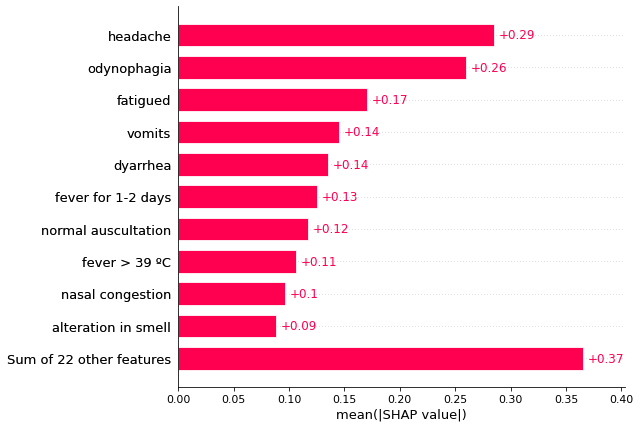

In [ ]:
shap.plots.bar(shapValsTestWhole.abs.mean(0), max_display=11, show=False)
plot = plt.gcf()
plot.savefig('avg_whole.jpg', dpi=1000, bbox_inches='tight')
# shap.plots.bar(shapValsTestWhole, max_display=11)

By max. impact on the predictions

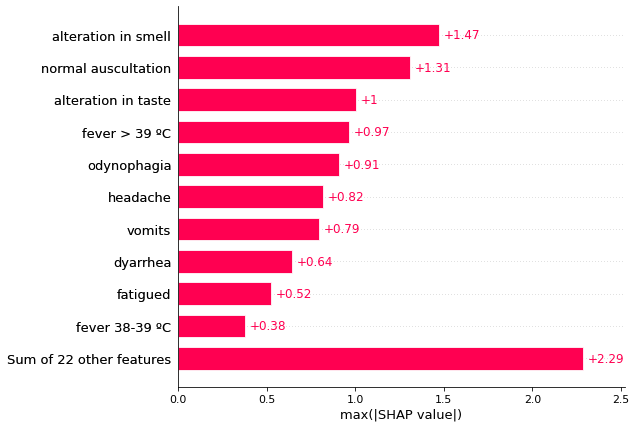

In [ ]:
shap.plots.bar(shapValsTestWhole.abs.max(0), max_display=11, show=False)
plot = plt.gcf()
plot.savefig('max_whole.jpg', dpi=1000, bbox_inches='tight')

Beeswarm plot, which allows us to see the degree of separation the model achieves for the features with top mean SHAP values.

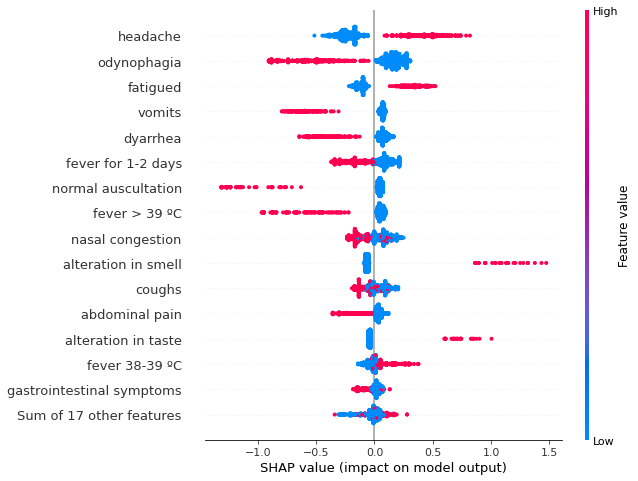

In [ ]:
plot = shap.plots.beeswarm(shapValsTestWhole, max_display=16, show=False)
plot = plt.gcf()
plot.savefig('bees_whole.jpg', dpi=1000, bbox_inches='tight')

### 6.2 Ages 0 to 5
The aged 0 to 5 dataset has been found to be best modeled by a Random Forest classifier. Again, we can use the Tree Explainer method from SHAP to obtain exact values in a fast way.

In [ ]:
exp0To5 = shap.Explainer(model=trainedModelFineGrid0To5, 
                         algorithm='tree',
                         feature_names=change_fnames(fNamesFineGrid0To5))
shapValsTest0To5 = exp0To5(testDataFineGrid0To5[0])

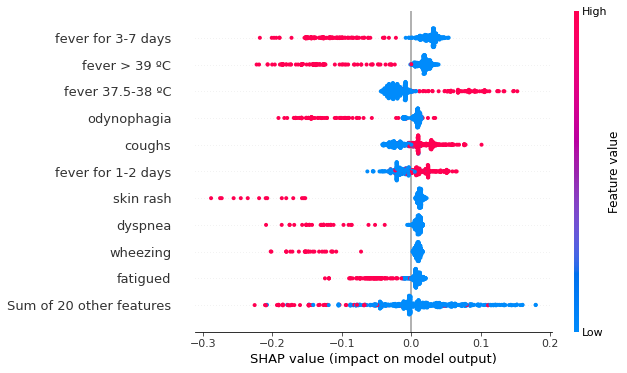

In [ ]:
shap.plots.beeswarm(shapValsTest0To5[:, :, 1], max_display=11, show=False)
plot = plt.gcf()
plot.savefig('bees_lt6.jpg', dpi=1000, bbox_inches='tight')

### 6.3 Ages > 6

The aged > 6 dataset has been found to be best modeled by a Random Forest. 

In [ ]:
exp6 = shap.Explainer(model=trainedModelFineGrid6To17,
                      algorithm='tree',
                      feature_names=change_fnames(fNamesFineGrid6To17))
shapValsTest6To17 = exp6(testDataFineGrid6To17[0])

# save them because computation times for kernelExplainer are somehow large
with open('/content/drive/MyDrive/BITSBITSBITS<3/shapVals6To17.pickle', 'wb') as handle:
  pickle.dump(shapValsTest6To17, handle)

In [ ]:
with open('/content/drive/MyDrive/BITSBITSBITS<3/shapVals6To17.pickle', 'rb') as handle:
  shapValsTest6To17 = pickle.load(handle)

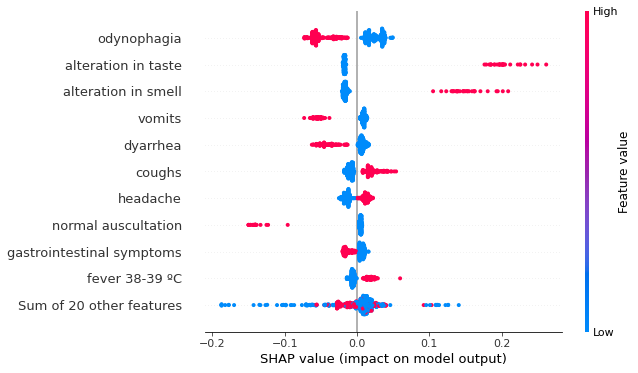

In [ ]:
shap.plots.beeswarm(shapValsTest6To17[:, :, 1], max_display=11, show=False)
plot = plt.gcf()
plot.savefig('bees_gt6.jpg', dpi=1000, bbox_inches='tight')

### 6.4 Ages > 6 (after feature selection)

In [ ]:
exp6FS = shap.KernelExplainer(model=FS617BestTrainedModel.predict_proba,
                            feature_names=change_fnames(FS617FNames),
                            data=np.zeros(len(FS617FNames)).reshape(1, -1))
shapValsTest6To17FS = exp6FS.shap_values(FS617TestData[0])

# save them because computation times for kernelExplainer are somehow large
with open('/content/drive/MyDrive/BITSBITSBITS<3/shapVals6To17FS.pickle', 'wb') as handle:
  pickle.dump(shapValsTest6To17FS, handle)

  0%|          | 0/632 [00:00<?, ?it/s]

In [ ]:
¡with open('/content/drive/MyDrive/BITSBITSBITS<3/shapVals6To17FS.pickle', 'rb') as handle:
  shapValsTest6To17FS = pickle.load(handle)

### Complementary

In [ ]:
import warnings

def topk_shap_features(k, shapVals, dataFeatures):
  """ Computes top k negative and positive features by mean shap value.

  :param shapVals: (ndarray) shap values
  :param dataFeatures: (ndarray) feature names of the data.
  :prints: 
    - top2*k mean abs value features
    - topk positive features
    - topk negative features
    - top2*k mean abs value shaps
    - topk mean positive shaps
    - topk mean negative shaps """

  meanShaps = np.mean(shapVals, axis=0)
  posShaps = meanShaps[meanShaps > 0]
  posFeatures = dataFeatures[meanShaps > 0]
  negShaps = meanShaps[meanShaps < 0]
  negFeatures = dataFeatures[meanShaps < 0]

  posSortedIndexes = np.argsort(-1*posShaps)
  negSortedIndexes = np.argsort(negShaps)
  allSortedIndexes = np.argsort(-1*np.abs(meanShaps))

  posShaps = posShaps[posSortedIndexes]
  posFeatures = posFeatures[posSortedIndexes]
  negShaps = negShaps[negSortedIndexes]
  negFeatures = negFeatures[negSortedIndexes]

  meanShaps = meanShaps[allSortedIndexes]
  sortedDataFeatures = dataFeatures[allSortedIndexes]

  assert k <= len(dataFeatures), 'k must be smaller than the number of features.' 

  if len(posShaps) < k:
    warnings.warn(f'Not enough positive features (only found {len(posShaps)})')
  if len(negShaps) < k:
    warnings.warn(f'Not enough negative features (only found {len(negShaps)})')
  if len(meanShaps) < 2*k:
    warnings.warn(f'Not enough total features (only {len(meanShaps)})')

  print(f'TOP {2*k} FEATURES THAT AFFECT THE PROBABILITY:')
  for val, f in zip(meanShaps[:2*k], sortedDataFeatures[:2*k]):
    print(f'{f}: {val}')

  print(f'\nTOP {k} FEATURES THAT POSITIVELY AFFECT THE PROBABILITY:')
  for val, f in zip(posShaps[:k], posFeatures[:k]):
    print(f'{f}: {val}')

  print(f'\nTOP {k} FEATURES THAT NEGATIVELY AFFECT THE PROBABILITY:')
  for val, f in zip(negShaps[:k], negFeatures[:k]):
    print(f'{f}: {val}')